# ReRoPE Benchmarks

In [1]:
!pip3 install seaborn
!pip3 install latex
!pip3 install mycolorpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


## Imports

In [2]:
import sys
import os
os.chdir( '/home/lhk3/memory-transformer-pt4/src' )
print( os.getcwd() )

from functools import cache
from typing import Tuple, cast

import numpy as np
import torch

from transformers import AutoTokenizer
from datasets import Dataset

import pandas as pd

import tqdm

from matplotlib import pyplot as plt # type: ignore
import seaborn as sns
from mycolorpy import colorlist as mcp

from model.modeling import LSWTForCausalLM
from constants import HF_CACHE_DIR
from training.data import load_gov_reports, load_pg19, load_wikitext
from training.losses import MLELoss, AccuracyMetric
from model.layers import RotaryEmbedding

os.chdir( '/home/lhk3/memory-transformer-pt4/' )
print( os.getcwd() )

/home/lhk3/memory-transformer-pt4/src


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/lhk3/memory-transformer-pt4


## Setup

In [3]:
import torch._dynamo.config
import torch.backends.cuda
import torch.backends.cudnn

torch._dynamo.config.cache_size_limit = 1024 * 1024
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.deterministic = False

In [4]:
os.chdir( '/home/lhk3/memory-transformer-pt4/' )
print( os.getcwd() )

/home/lhk3/memory-transformer-pt4


In [5]:
path_2048_re = './checkpoints/rich-bee-76'
path_2048 = './checkpoints/rare-violet-77'
path_1024_re = './checkpoints/skilled-elevator-80'
path_1024 = './checkpoints/fresh-butterfly-83'

model_2048_re = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048_re ) ).half().cuda().eval()
model_2048 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048 ) ).half().cuda().eval()

model_2048_re_abf2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048_re, rope_ntk_scale=2.0 ) ).half().cuda().eval()
model_2048_abf2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048, rope_ntk_scale=2.0 ) ).half().cuda().eval()

model_2048_re_abf4 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048_re, rope_ntk_scale=4.0 ) ).half().cuda().eval()
model_2048_abf4 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048, rope_ntk_scale=4.0 ) ).half().cuda().eval()

model_1024_re = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024_re ) ).half().cuda().eval()
model_1024 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024 ) ).half().cuda().eval()

model_1024_re_abf2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024_re, rope_ntk_scale=2.0 ) ).half().cuda().eval()
model_1024_abf2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024, rope_ntk_scale=2.0 ) ).half().cuda().eval()

model_1024_re_abf4 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024_re, rope_ntk_scale=4.0 ) ).half().cuda().eval()
model_1024_abf4 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024, rope_ntk_scale=4.0 ) ).half().cuda().eval()

torch.cuda.empty_cache()

In [6]:
tokenizer = AutoTokenizer.from_pretrained( model_2048_re.config.parent_embeddings, use_fast=True, cache_dir=HF_CACHE_DIR )

dataset_pg19_v = cast( Dataset, load_pg19( HF_CACHE_DIR, 'validation' ) )
dataset_pg19_t = cast( Dataset, load_pg19( HF_CACHE_DIR, 'test' ) )
dataset_wiki = cast( Dataset, load_wikitext( HF_CACHE_DIR ) )
dataset_gov = cast( Dataset, load_gov_reports( HF_CACHE_DIR, 'test' ) )

loss_function = MLELoss( model_2048_re.config.vocab_size, -100 )
acc_function = AccuracyMetric( model_2048_re.config.vocab_size, -100 )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for pg19 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pg19
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for tau/scrolls contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tau/scrolls
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
def do_experiment( dataset: Dataset, key: str, model: LSWTForCausalLM, context_lens: list[int], cont_stride: int ):
    dataset_len = len( dataset )

    @cache
    def tokenize_example( idx: int, chunk_size: int ) -> Tuple[ torch.LongTensor, torch.LongTensor, int ]:
        tokens = tokenizer.encode( dataset[idx][key], add_special_tokens=False )
        
        tokens_x = [ tokenizer.bos_token_id ] + tokens
        tokens_y = tokens + [ tokenizer.eos_token_id ]
        
        orig_len = len( tokens_x )
        pad_amt = chunk_size - ( orig_len % chunk_size )
        
        tokens_x = tokens_x + pad_amt * [ tokenizer.pad_token_id ]
        tokens_y = tokens_y + pad_amt * [ -100 ]
        
        tokens_x = torch.LongTensor( [ tokens_x ] )
        tokens_y = torch.LongTensor( [ tokens_y ] )
        
        return tokens_x, tokens_y, orig_len

    def get_num_true( tokens_y, pad_token_id=-100 ):
        return ( tokens_y != pad_token_id ).sum()

    @torch.no_grad()
    def evaluate(
        model: LSWTForCausalLM,
        tokens_x: torch.LongTensor,
        tokens_y: torch.LongTensor,
        chunk_size: int,
        max_context: int,
    ):
        max_cache_size = max_context - chunk_size
        
        tokens_xs = torch.split( tokens_x.cuda(), chunk_size, dim=1 )
        tokens_ys = torch.split( tokens_y.cuda(), chunk_size, dim=1 )
        
        loss = 0.0
        accuracy = 0.0
        total_num_true = 0
        
        past_key_values = None

        for tx, ty in zip( tokens_xs, tokens_ys ):
            outputs = model(
                input_ids=tx,
                past_key_values=past_key_values,
                use_cache=True,
                max_key_values=max_cache_size,
            )

            past_key_values = outputs.past_key_values
            logits = outputs.logits.float()

            num_true = get_num_true( ty )

            if num_true > 0:
                total_num_true += num_true
                loss += loss_function( None, logits, None, ty )[0] * num_true
                accuracy += acc_function( logits, ty ) * num_true

        loss /= total_num_true
        accuracy /= total_num_true
        
        return float( loss ), float( accuracy )

    def tokenize_eval(
        idx: int,
        model: LSWTForCausalLM,
        chunk_size: int,
        max_context: int,
    ):
        tokens_x, tokens_y, _ = tokenize_example( idx, chunk_size )
        loss, acc = evaluate( model, tokens_x, tokens_y, chunk_size, max_context )
        
        return loss, acc

    def eval_range( idx, model, chunk_size, contexts ):
        text_len = tokenize_example( idx, 1 )[2]
        
        loss_s = []
        acc_s=[]
        
        record = True
        
        for max_context in contexts:
            loss, acc = tokenize_eval( idx, model, chunk_size, max_context )
            
            if record:
                loss_s.append( loss )
                acc_s.append( acc )
            else:
                loss_s.append( None )
                acc_s.append( None )
            
            if max_context > text_len:
                record = False
        
        return text_len, loss_s, acc_s

    def eval_range_dict( idx, model, chunk_size, contexts ):
        text_len, loss_s, acc_s = eval_range( idx, model, chunk_size, contexts )
        
        output_loss = { 'length': text_len }
        output_acc = { 'length': text_len }

        for length, loss, acc in zip( contexts, loss_s, acc_s ):
            output_loss[ f'l_{length}' ] = loss
            output_acc[ f'a_{length}' ] = acc

        return output_loss, output_acc

    iterator = tqdm.tqdm( range( dataset_len ), smoothing=0.0, ncols=64 )

    data_loss: list[dict] = []
    data_acc: list[dict] = []

    for i in iterator:
        loss_dict, acc_dict = eval_range_dict( i, model, cont_stride, context_lens )
        data_loss.append( loss_dict )
        data_acc.append( acc_dict )
        
        print( '', end='', flush=True )
    # print()

    df_loss = pd.DataFrame.from_dict( data_loss ) # type: ignore
    df_acc = pd.DataFrame.from_dict( data_acc ) # type: ignore
    
    return df_loss, df_acc

In [8]:
import matplotlib.ticker as ticker

sns.set(
    style='whitegrid',
)


def compare_graph( dfs, names, colours, x_axis, metric, graph_title ):
    counts = [ df.describe().iloc[0].to_numpy()[1:] for df in dfs ]
    means = [ df.describe().iloc[1].to_numpy()[1:] for df in dfs ]
    stds = [ df.describe().iloc[2].to_numpy()[1:] for df in dfs ]

    x = [ i for i in x_axis ]
    x_ticks = [ i for i in x_axis ]
    
    x_ticks[ 1 : : 2 ] = [ None for _ in x_ticks[ 1 : : 2 ] ]

    plt.figure( 1, ( 12, 6 ), dpi=192 )
    
    for i, ( c, y, e ) in enumerate( zip( counts, means, stds ) ):
        # 95% confidence limit calculation
        clm95 = 1.96 * e / np.sqrt( c )
        
        # plt.errorbar( x, y, clm95, fmt='-x', capsize=4, capthick=1, linewidth=1, color=f'C{i}' )
        plt.plot( x, y, marker='x', linewidth=1, color=colours[i] )
        plt.fill_between( x, y - clm95, y + clm95, color=colours[i], alpha=0.1, interpolate=True )
    
    label_names = [ None ] * len( names ) * 2
    label_names[ 0 : : 2 ] = names
    label_names[ 1 : : 2 ] = [ '_nolegend_' for _ in names ]

    plt.title( graph_title.format( metric=metric ) )
    plt.xticks( x, x_ticks )
    plt.grid( axis='x' )
    plt.gca().spines['top'].set_visible( False )
    plt.gca().spines['right'].set_visible( False )
    plt.tick_params( bottom=True, color=( 0.8, 0.8, 0.8, 1.0 ), labelcolor='black' )
    # plt.gca().set_ylim(bottom=0)
    plt.xlabel( 'Context Length', color='black' )
    plt.ylabel( metric, color='black' )
    plt.legend( label_names )
    plt.gca().set_xlim( left=x_axis[0], right=x_axis[-1] )
    plt.show()

In [9]:
def base_dataframe_names( model: str, dataset: str, cont_min: int, cont_max: int, cont_stride: int ):
    base_name = f'{dataset}/{model}_{cont_min}-{cont_max}-{cont_stride}'
    loss_name = f'./src/experiments/benchmark_rerope/{base_name}_loss.csv'
    acc_name = f'./src/experiments/benchmark_rerope/{base_name}_acc.csv'
    
    return loss_name, acc_name

def save_dataframes( loss_df: pd.DataFrame, acc_df: pd.DataFrame, model: str, dataset: str, cont_min: int, cont_max: int, cont_stride: int ):
    loss_name, acc_name = base_dataframe_names( model, dataset, cont_min, cont_max, cont_stride )
    
    loss_df.to_csv( loss_name, index=False )
    acc_df.to_csv( acc_name, index=False )

def load_or_save_dataframes(
    model,
    dataset,
    key,
    model_name,
    dataset_name,
    cont_min,
    cont_max,
    cont_stride
):
    context_lens = list( range( cont_min, cont_max + 1, cont_stride ) )
    loss_name, acc_name = base_dataframe_names( model_name, dataset_name, cont_min, cont_max, cont_stride )
    
    if os.path.exists( loss_name ) and os.path.exists( acc_name ):
        loss_df = pd.read_csv( loss_name )
        acc_df = pd.read_csv( acc_name )
    
    else:
        loss_df, acc_df = do_experiment( dataset, key, model, context_lens, cont_stride )
        save_dataframes( loss_df, acc_df, model_name, dataset_name, cont_min, cont_max, cont_stride )
    
    return loss_df, acc_df, context_lens

## Experiments

In [10]:
def compute_group( dataset_hf, dataset_key, dataset_name, cont_min, cont_max, cont_stride, graph_title, do_2k=True, do_1k=False ):
    loss_s = []
    acc_s = []
    name_s = []
    
    context_lens = list( range( cont_min, cont_max + 1, cont_stride ) )
    
    if do_2k:
        df_loss_2048_re, df_acc_2048_re, _ = load_or_save_dataframes( model_2048_re, dataset_hf, dataset_key, '2048-re', dataset_name, cont_min, cont_max, cont_stride )
        df_loss_2048, df_acc_2048, _ = load_or_save_dataframes( model_2048, dataset_hf, dataset_key, '2048', dataset_name, cont_min, cont_max, cont_stride )
        
        df_loss_2048_re_abf2, df_acc_2048_re_abf2, _ = load_or_save_dataframes( model_2048_re_abf2, dataset_hf, dataset_key, '2048-re-abf2', dataset_name, cont_min, cont_max, cont_stride )
        df_loss_2048_abf2, df_acc_2048_abf2, _ = load_or_save_dataframes( model_2048_abf2, dataset_hf, dataset_key, '2048-abf2', dataset_name, cont_min, cont_max, cont_stride )
        
        df_loss_2048_re_abf4, df_acc_2048_re_abf4, _ = load_or_save_dataframes( model_2048_re_abf4, dataset_hf, dataset_key, '2048-re-abf4', dataset_name, cont_min, cont_max, cont_stride )
        df_loss_2048_abf4, df_acc_2048_abf4, _ = load_or_save_dataframes( model_2048_abf4, dataset_hf, dataset_key, '2048-abf4', dataset_name, cont_min, cont_max, cont_stride )
        
        loss_s += [ df_loss_2048, df_loss_2048_abf2, df_loss_2048_abf4, df_loss_2048_re, df_loss_2048_re_abf2, df_loss_2048_re_abf4 ]
        acc_s += [ df_acc_2048, df_acc_2048_abf2, df_acc_2048_abf4, df_acc_2048_re, df_acc_2048_re_abf2, df_acc_2048_re_abf4 ]
        name_s += [ '2K4K RoPE', '2K4K RoPE NTK=2', '2K4K RoPE NTK=4', r'2K4K $\bf{Re}$RoPE', r'2K4K $\bf{Re}$RoPE NTK=2', r'2K4K $\bf{Re}$RoPE NTK=4' ]
    
    if do_1k:
        df_loss_1024_re, df_acc_1024_re, _ = load_or_save_dataframes( model_1024_re, dataset_hf, dataset_key, '1024-re', dataset_name, cont_min, cont_max, cont_stride )
        df_loss_1024, df_acc_1024, _ = load_or_save_dataframes( model_1024, dataset_hf, dataset_key, '1024', dataset_name, cont_min, cont_max, cont_stride )
        
        df_loss_1024_re_abf2, df_acc_1024_re_abf2, _ = load_or_save_dataframes( model_1024_re_abf2, dataset_hf, dataset_key, '1024-re-abf2', dataset_name, cont_min, cont_max, cont_stride )
        df_loss_1024_abf2, df_acc_1024_abf2, _ = load_or_save_dataframes( model_1024_abf2, dataset_hf, dataset_key, '1024-abf2', dataset_name, cont_min, cont_max, cont_stride )
        
        df_loss_1024_re_abf4, df_acc_1024_re_abf4, _ = load_or_save_dataframes( model_1024_re_abf4, dataset_hf, dataset_key, '1024-re-abf4', dataset_name, cont_min, cont_max, cont_stride )
        df_loss_1024_abf4, df_acc_1024_abf4, _ = load_or_save_dataframes( model_1024_abf4, dataset_hf, dataset_key, '1024-abf4', dataset_name, cont_min, cont_max, cont_stride )
        
        loss_s += [ df_loss_1024, df_loss_1024_abf2, df_loss_1024_abf4, df_loss_1024_re, df_loss_1024_re_abf2, df_loss_1024_re_abf4 ]
        acc_s += [ df_acc_1024, df_acc_1024_abf2, df_acc_1024_abf4, df_acc_1024_re, df_acc_1024_re_abf2, df_acc_1024_re_abf4 ]
        name_s += [ '1K2K RoPE', '1K2K RoPE NTK=2', '1K2K RoPE NTK=4', r'1K2K $\bf{Re}$RoPE', r'1K2K $\bf{Re}$RoPE NTK=2', r'1K2K $\bf{Re}$RoPE NTK=4' ]

    colours = mcp.gen_color( cmap='tab20', n=20 )
    # colour_map = [ 1, 3, 5, 0, 2, 4, ]
    colour_map = [ 0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11 ]
    
    colours = [ colours[i] for i in colour_map ]

    compare_graph(
        dfs=loss_s,
        names=name_s,
        colours=colours,
        x_axis=context_lens,
        metric='Loss',
        graph_title=graph_title
    )
    compare_graph(
        dfs=acc_s,
        names=name_s,
        colours=colours,
        x_axis=context_lens,
        metric='Accuracy',
        graph_title=graph_title
    )

### WikiText-V

WikiText Validation Set - {metric} @ Context Length


/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


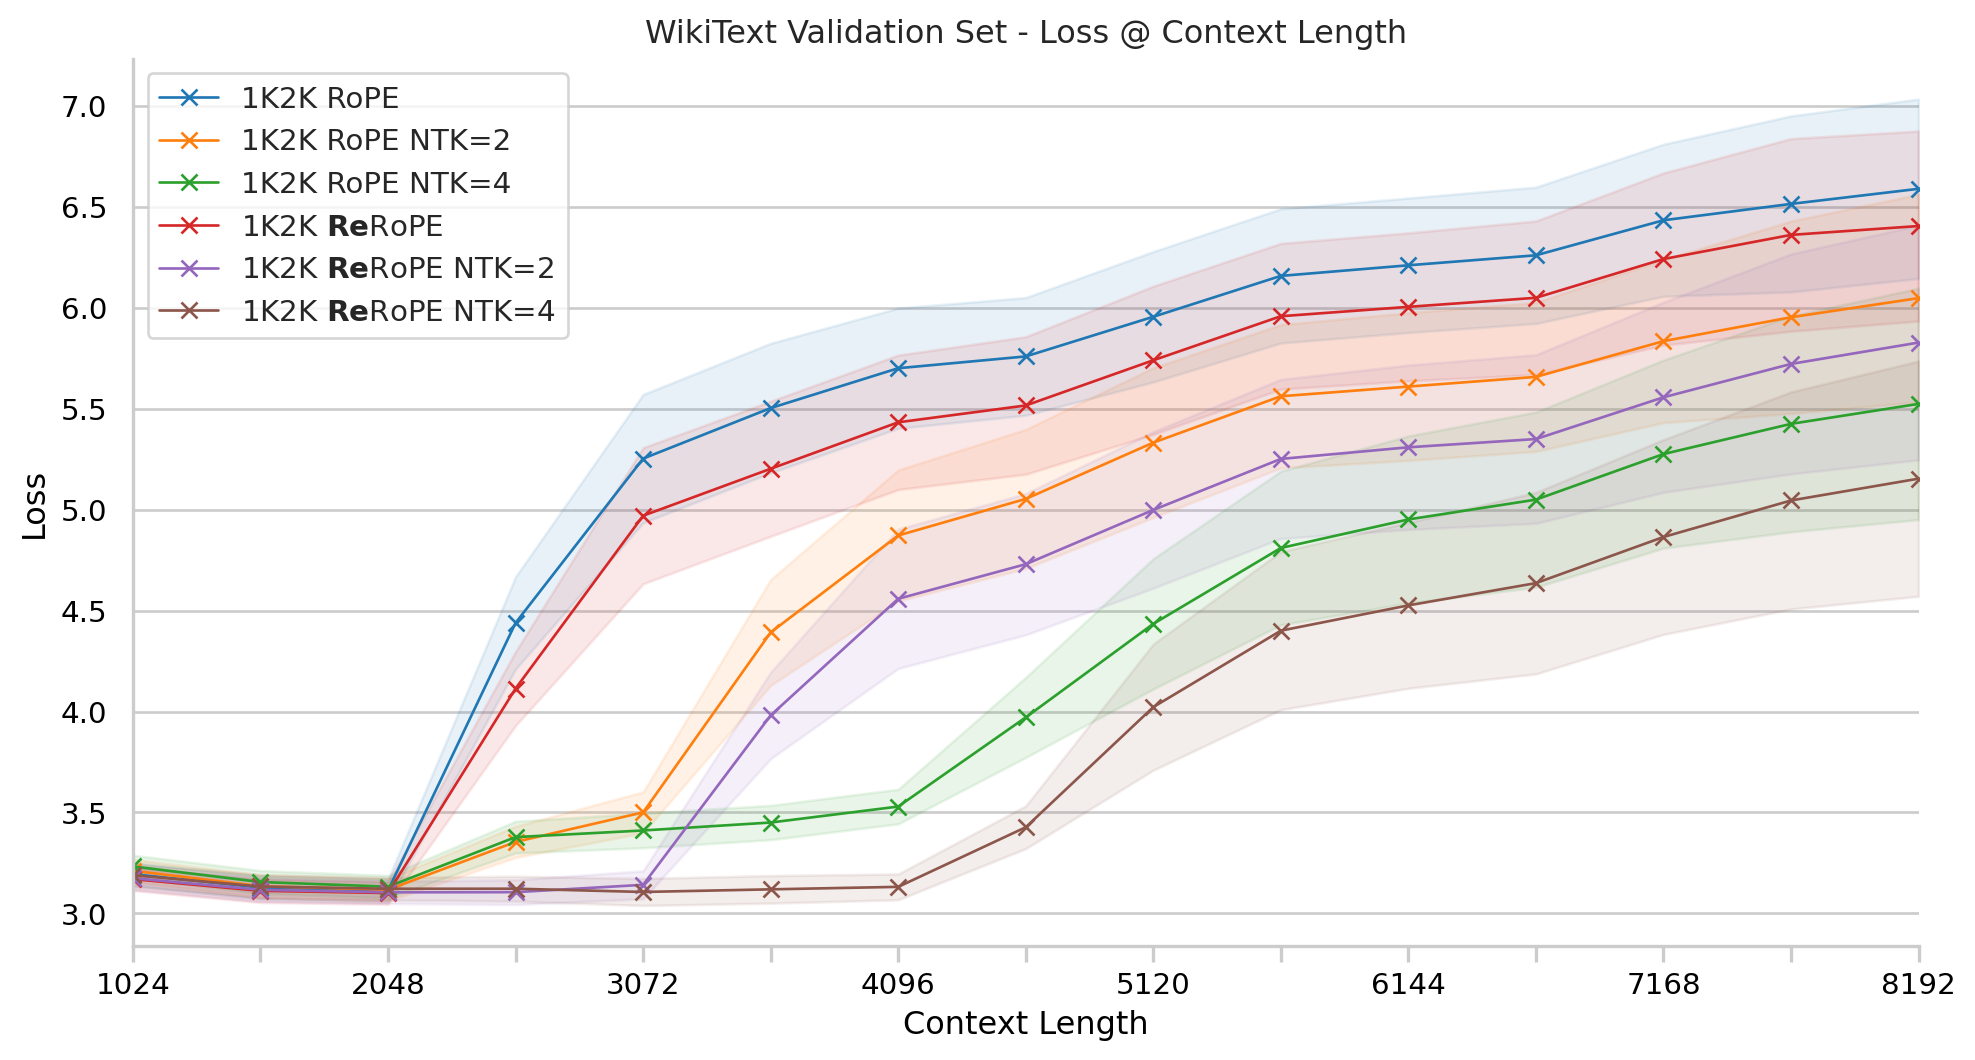

/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


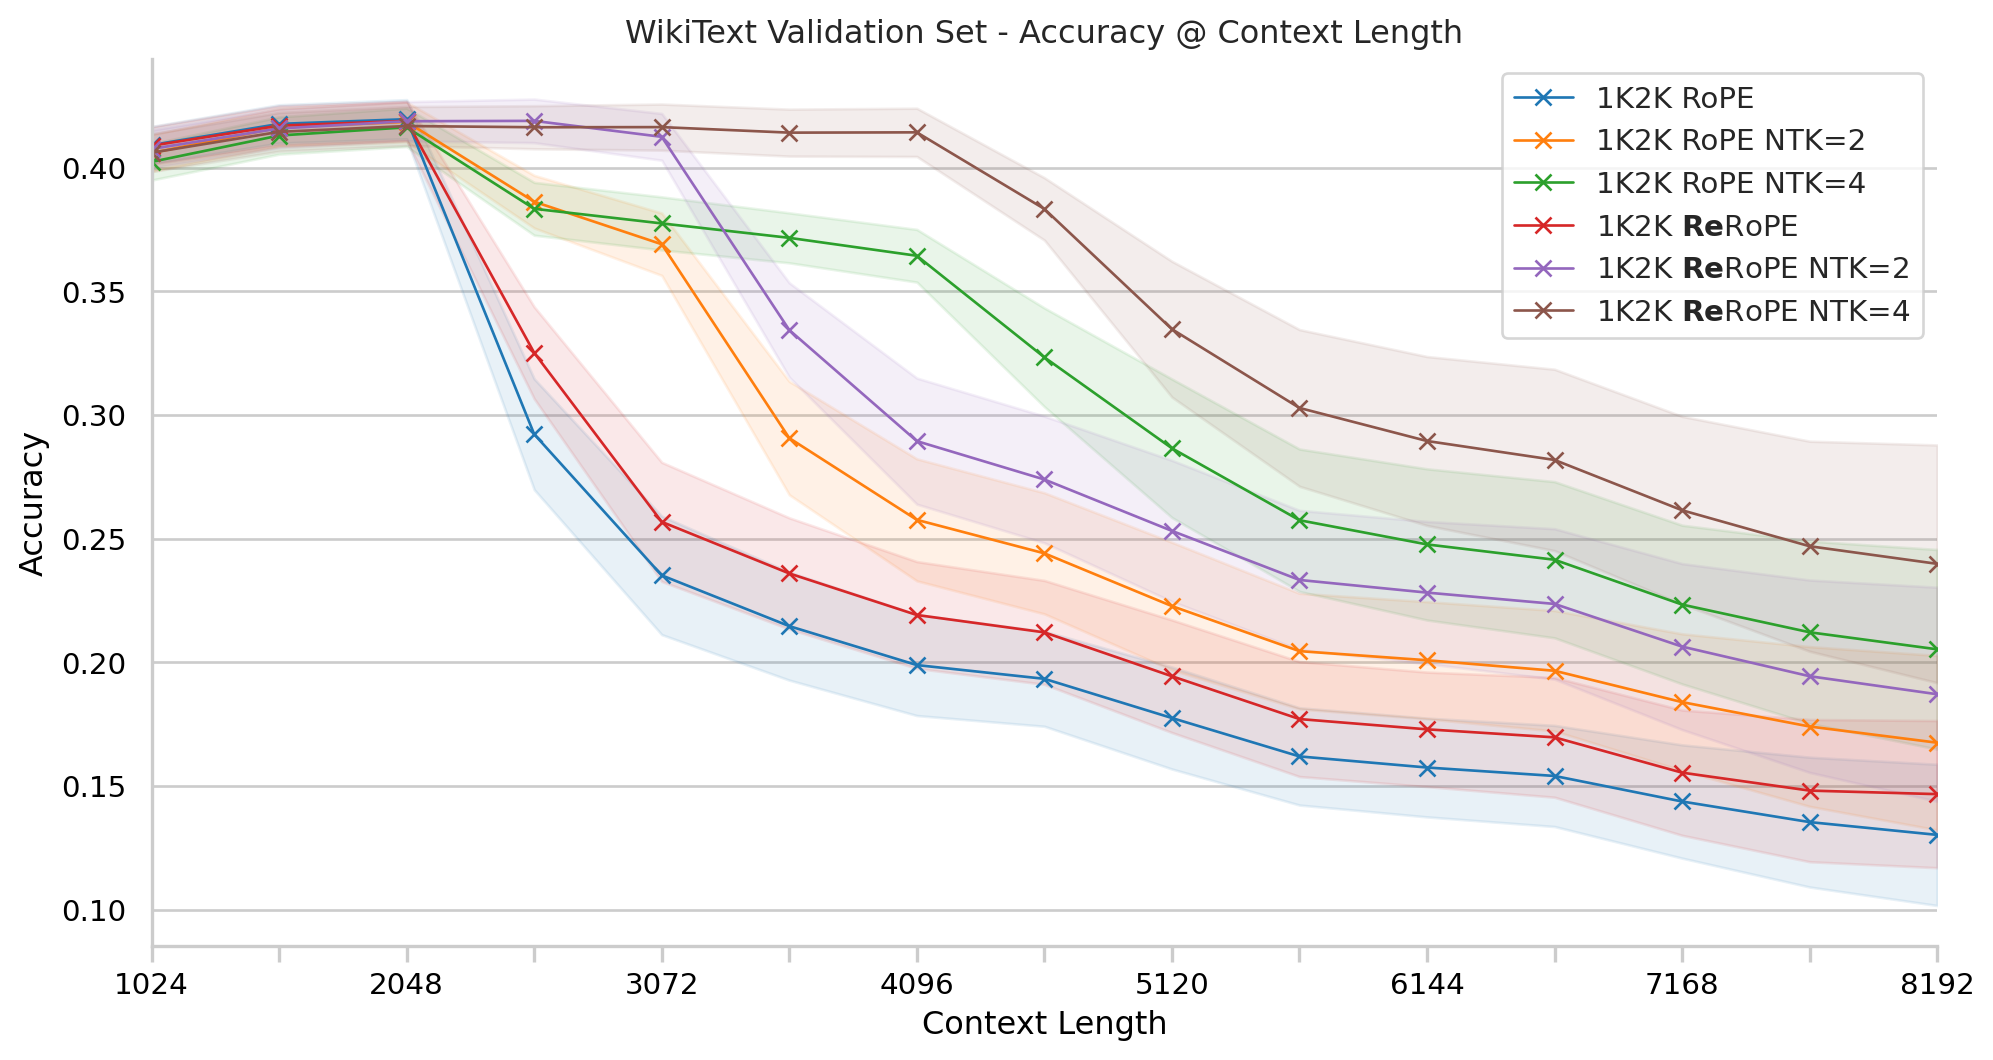

In [11]:
graph_title = 'WikiText Validation Set - {metric} @ Context Length'
print( graph_title )

cont_min = 1024
cont_max = 8192
cont_stride = 512

dataset_hf = dataset_wiki
dataset_name = 'wikitext-v'
dataset_key = 'page'

compute_group( dataset_hf, dataset_key, dataset_name, cont_min, cont_max, cont_stride, graph_title, False, True )

WikiText Validation Set - {metric} @ Context Length


/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


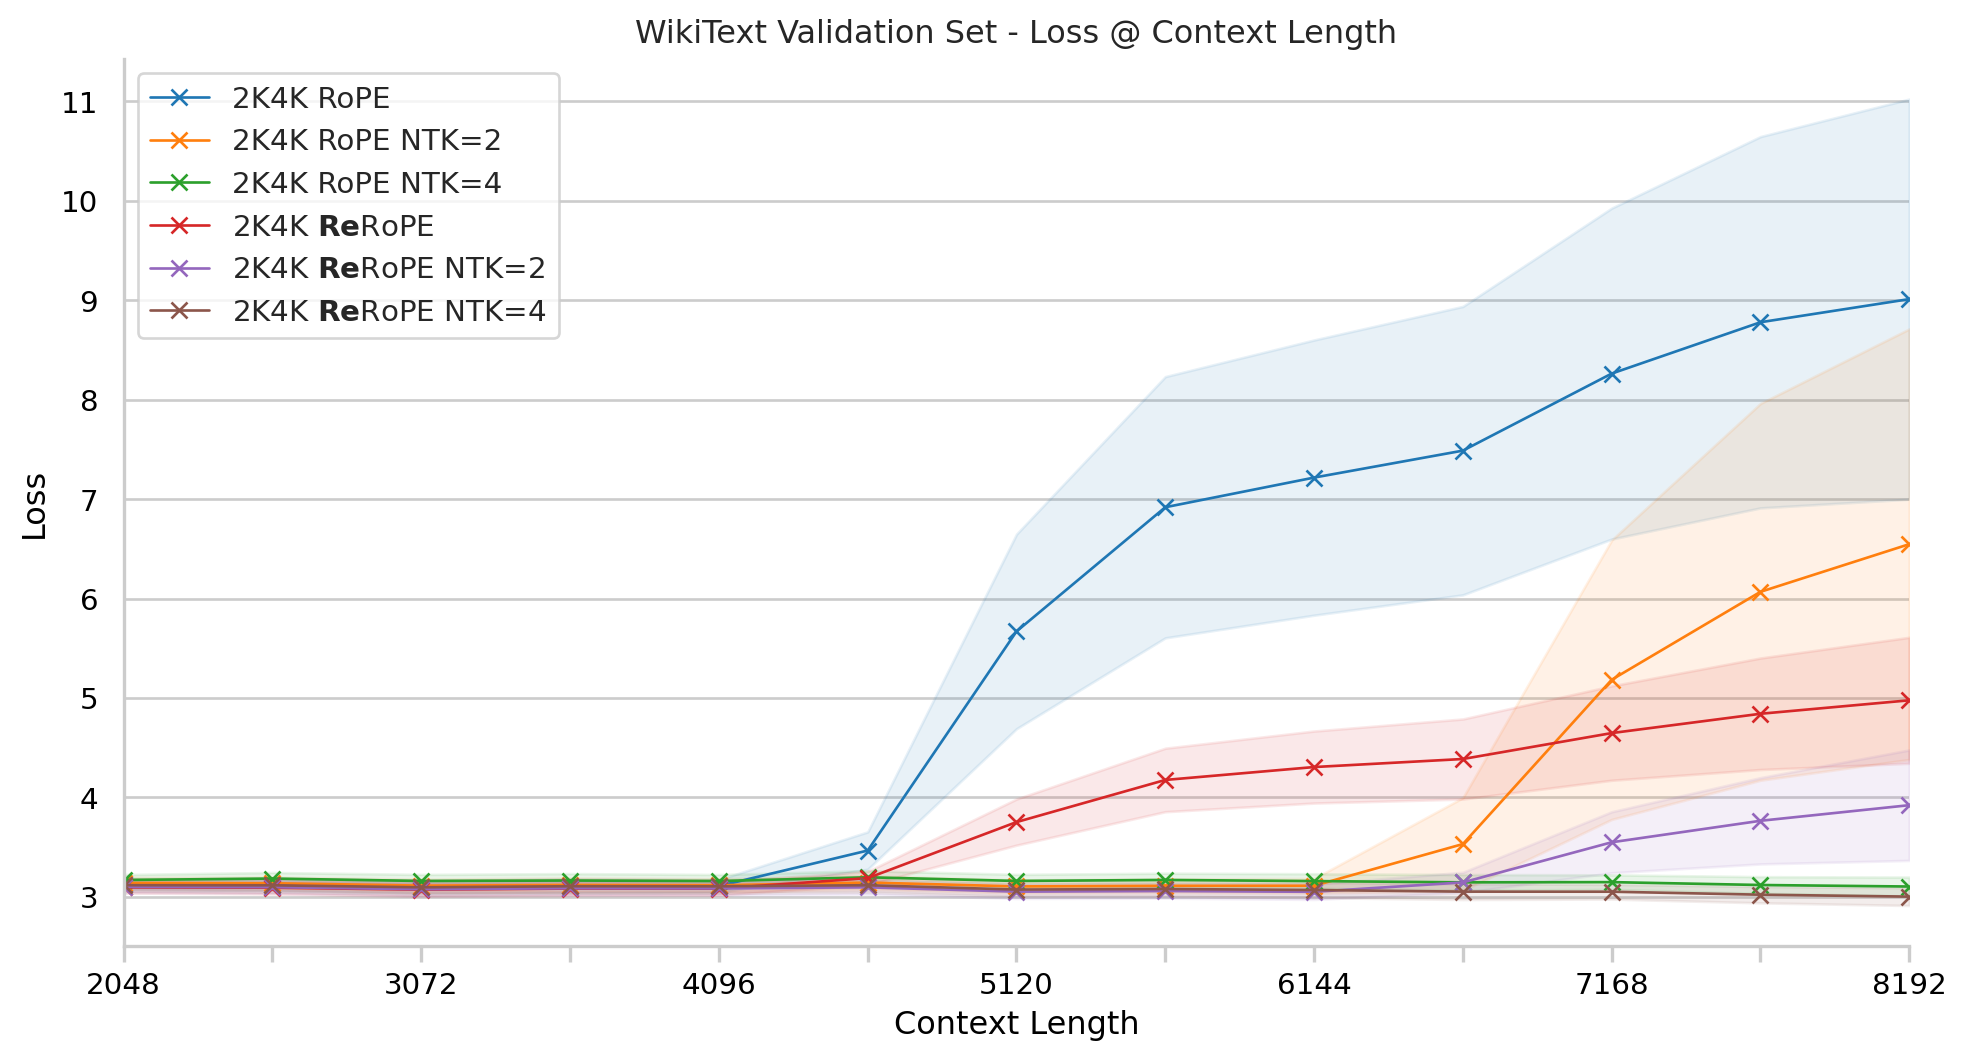

/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


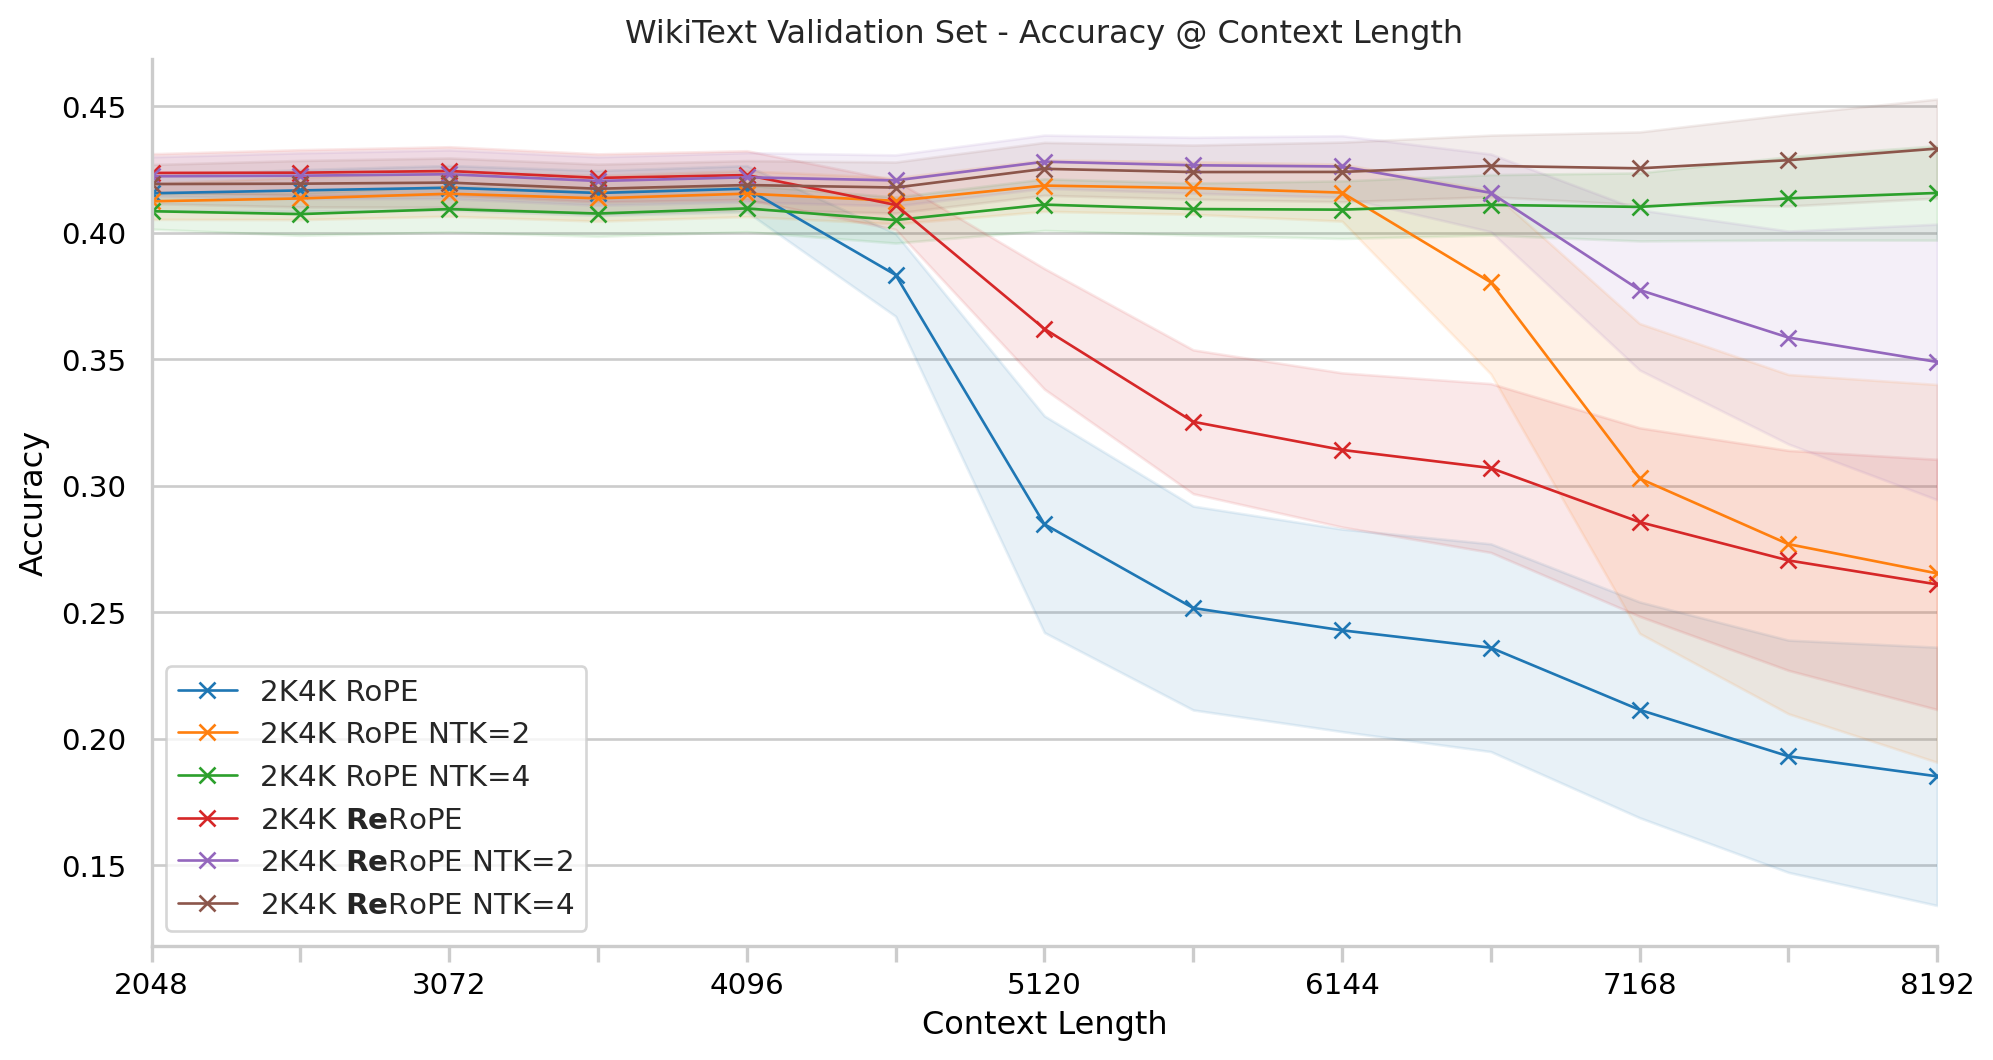

In [12]:
graph_title = 'WikiText Validation Set - {metric} @ Context Length'
print( graph_title )

cont_min = 2048
cont_max = 8192
cont_stride = 512

dataset_hf = dataset_wiki
dataset_name = 'wikitext-v'
dataset_key = 'page'

compute_group( dataset_hf, dataset_key, dataset_name, cont_min, cont_max, cont_stride, graph_title, True, False )

### PG-19-V

PG-19 Validation Set - {metric} @ Context Length


/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


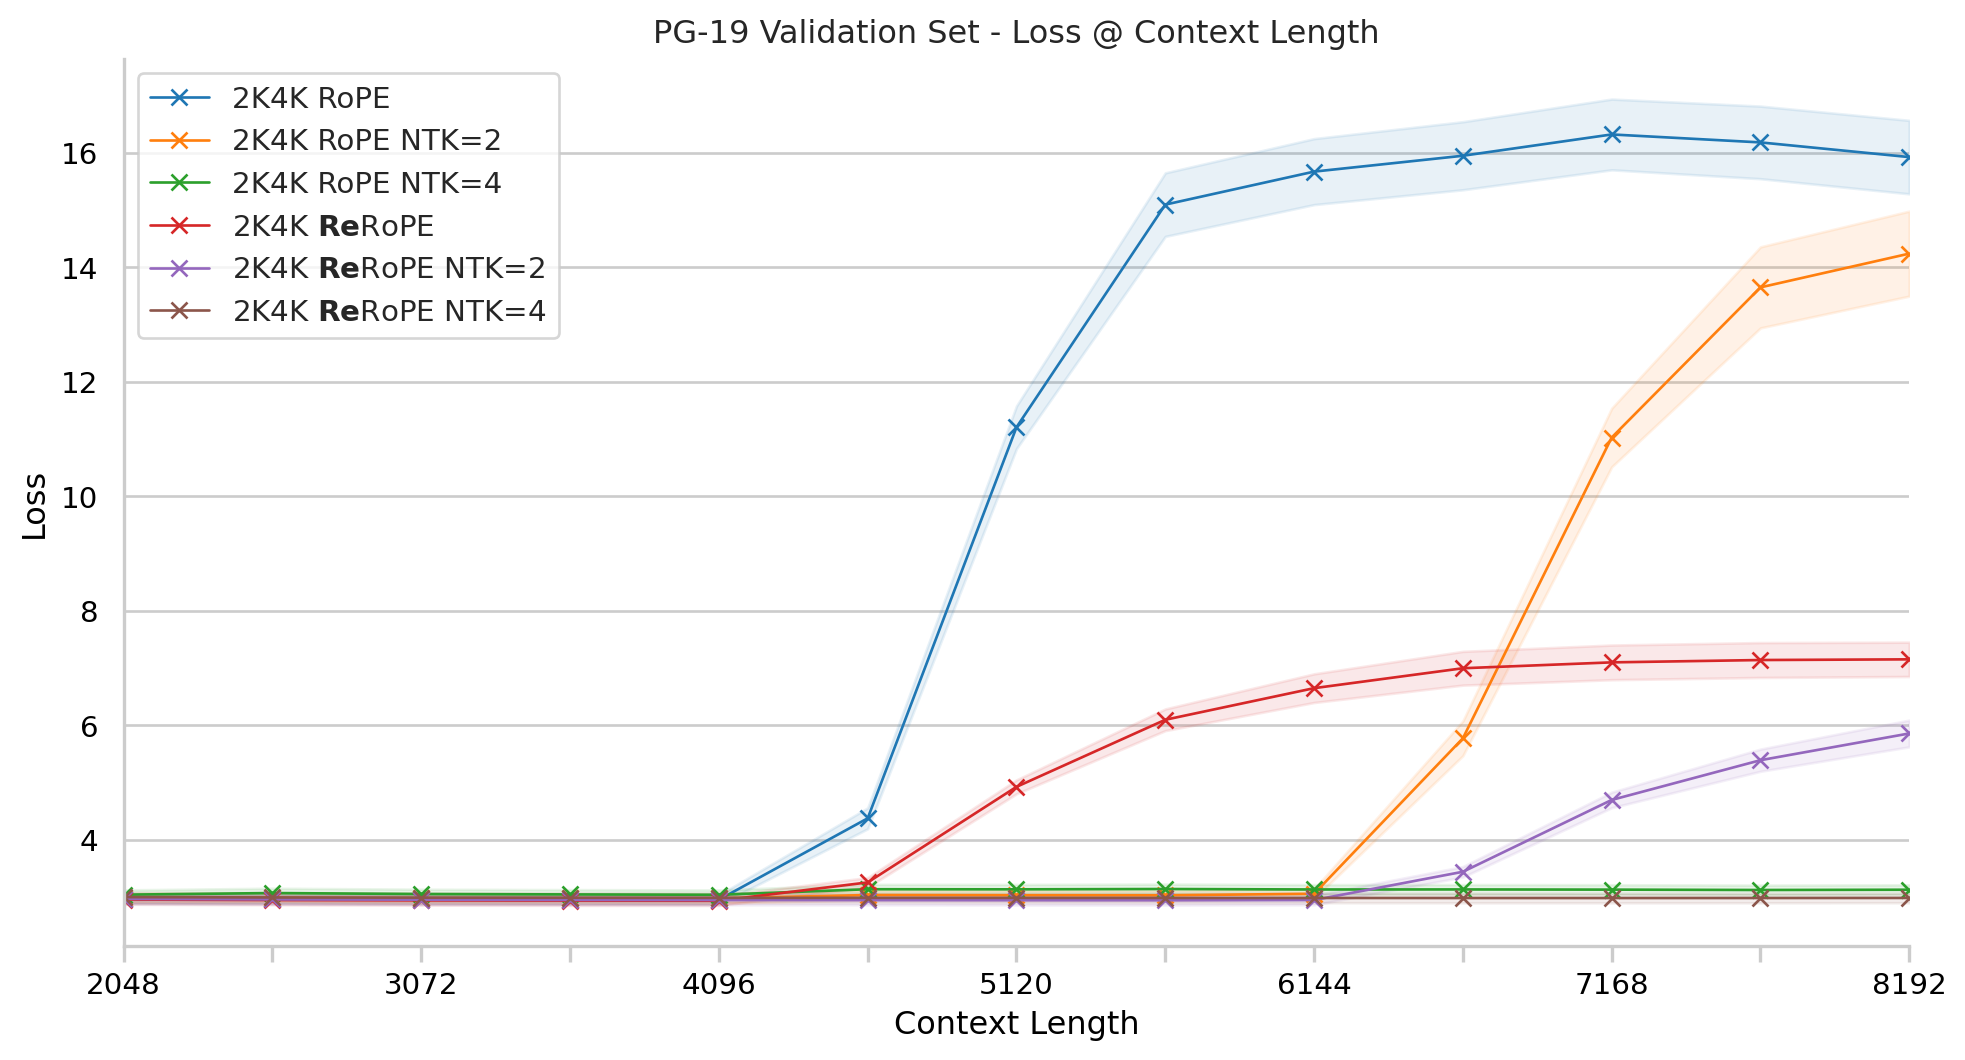

/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


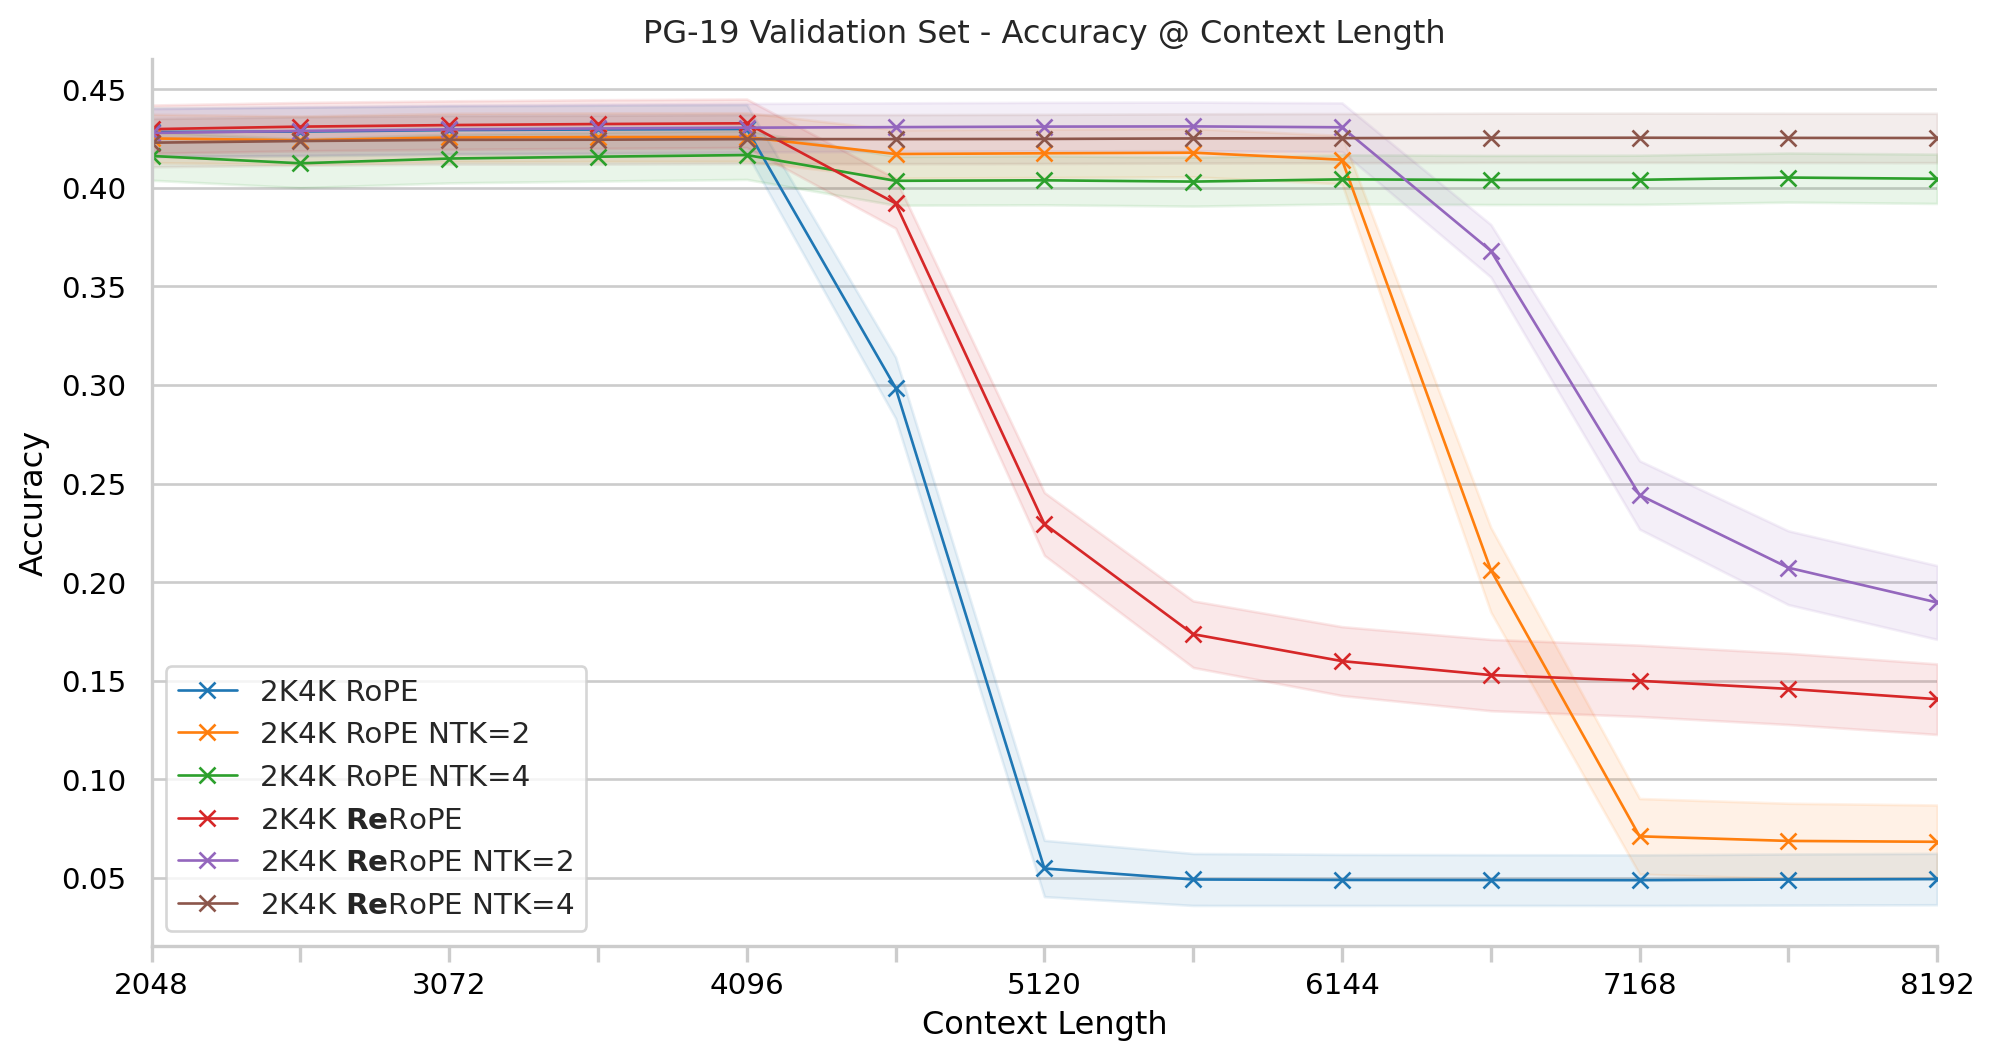

In [13]:
graph_title = 'PG-19 Validation Set - {metric} @ Context Length'
print( graph_title )

cont_min = 2048
cont_max = 8192
cont_stride = 512
context_lens = list( range( cont_min, cont_max + 1, cont_stride ) )

dataset_hf = dataset_pg19_v
dataset_name = 'pg19-v'
dataset_key = 'text'

compute_group( dataset_hf, dataset_key, dataset_name, cont_min, cont_max, cont_stride, graph_title )

### PG-19-T

PG-19 Test Set - {metric} @ Context Length


/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


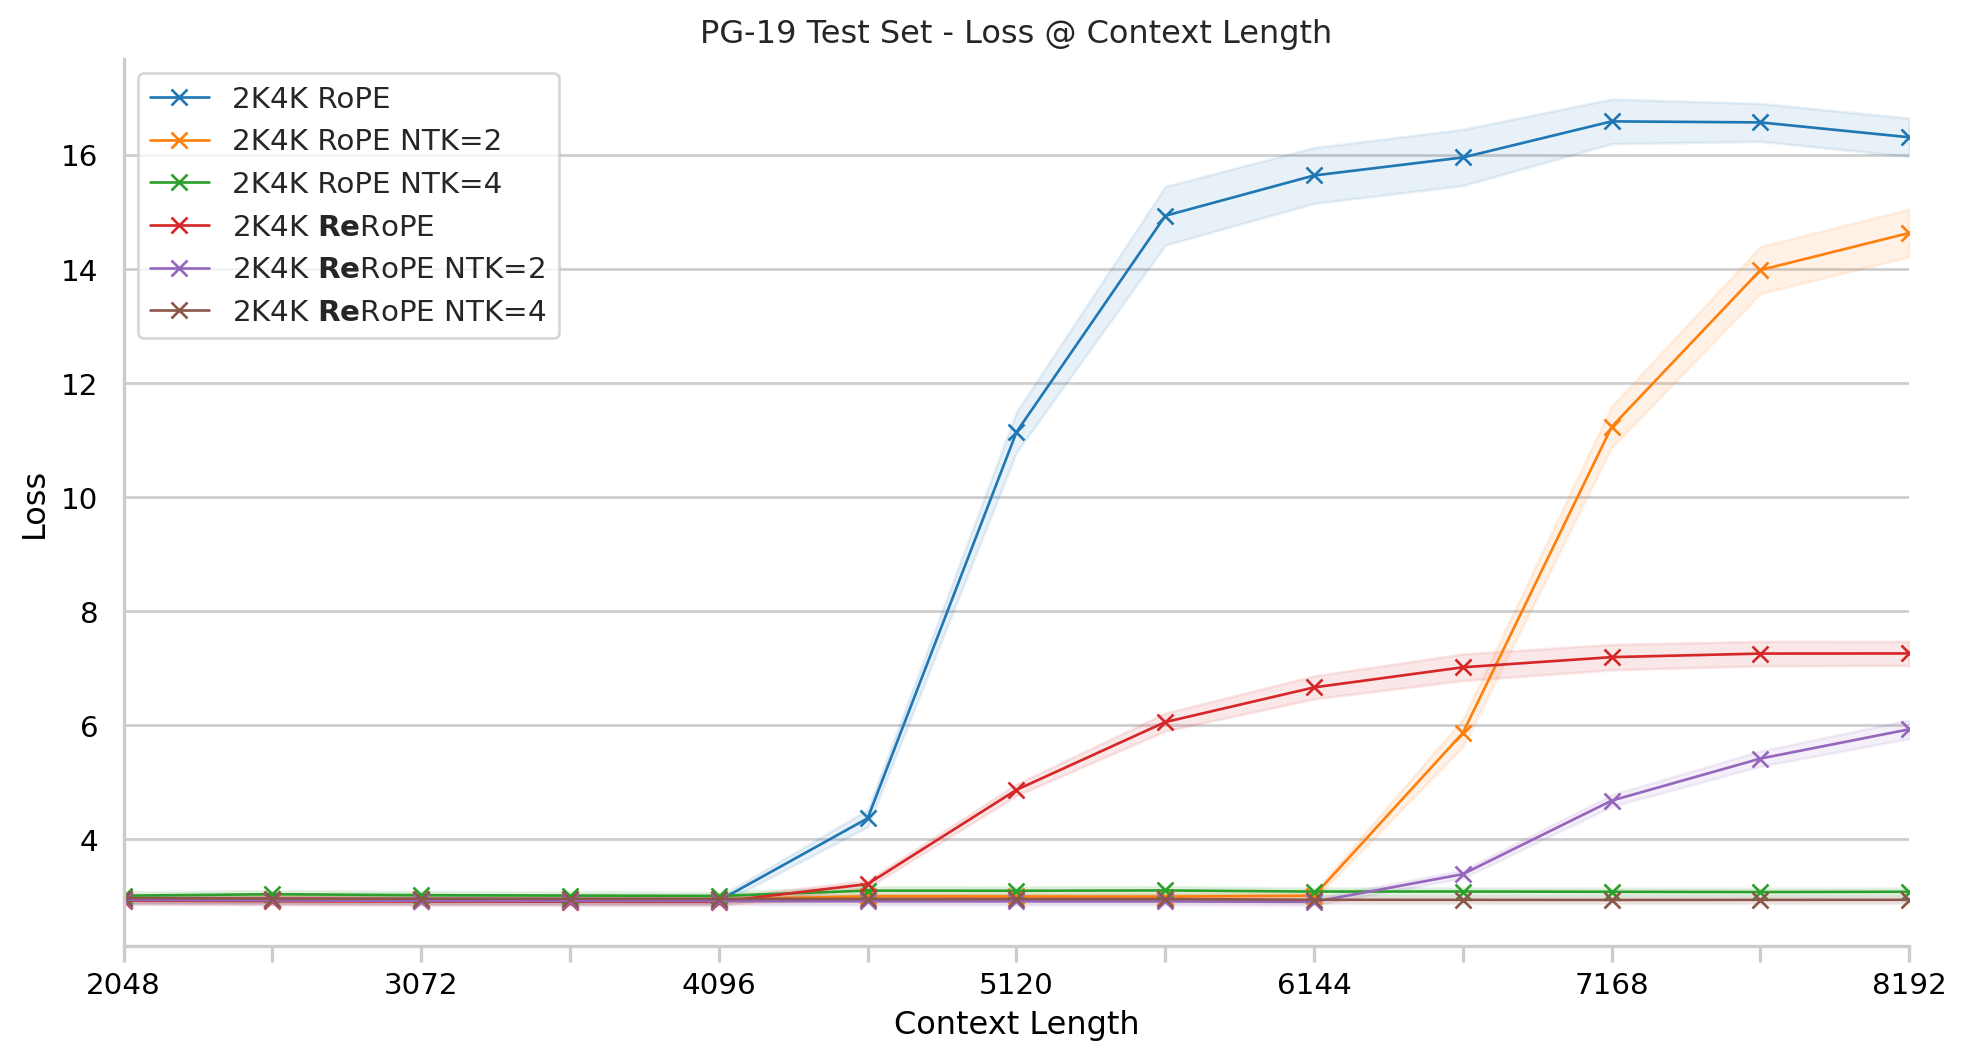

/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


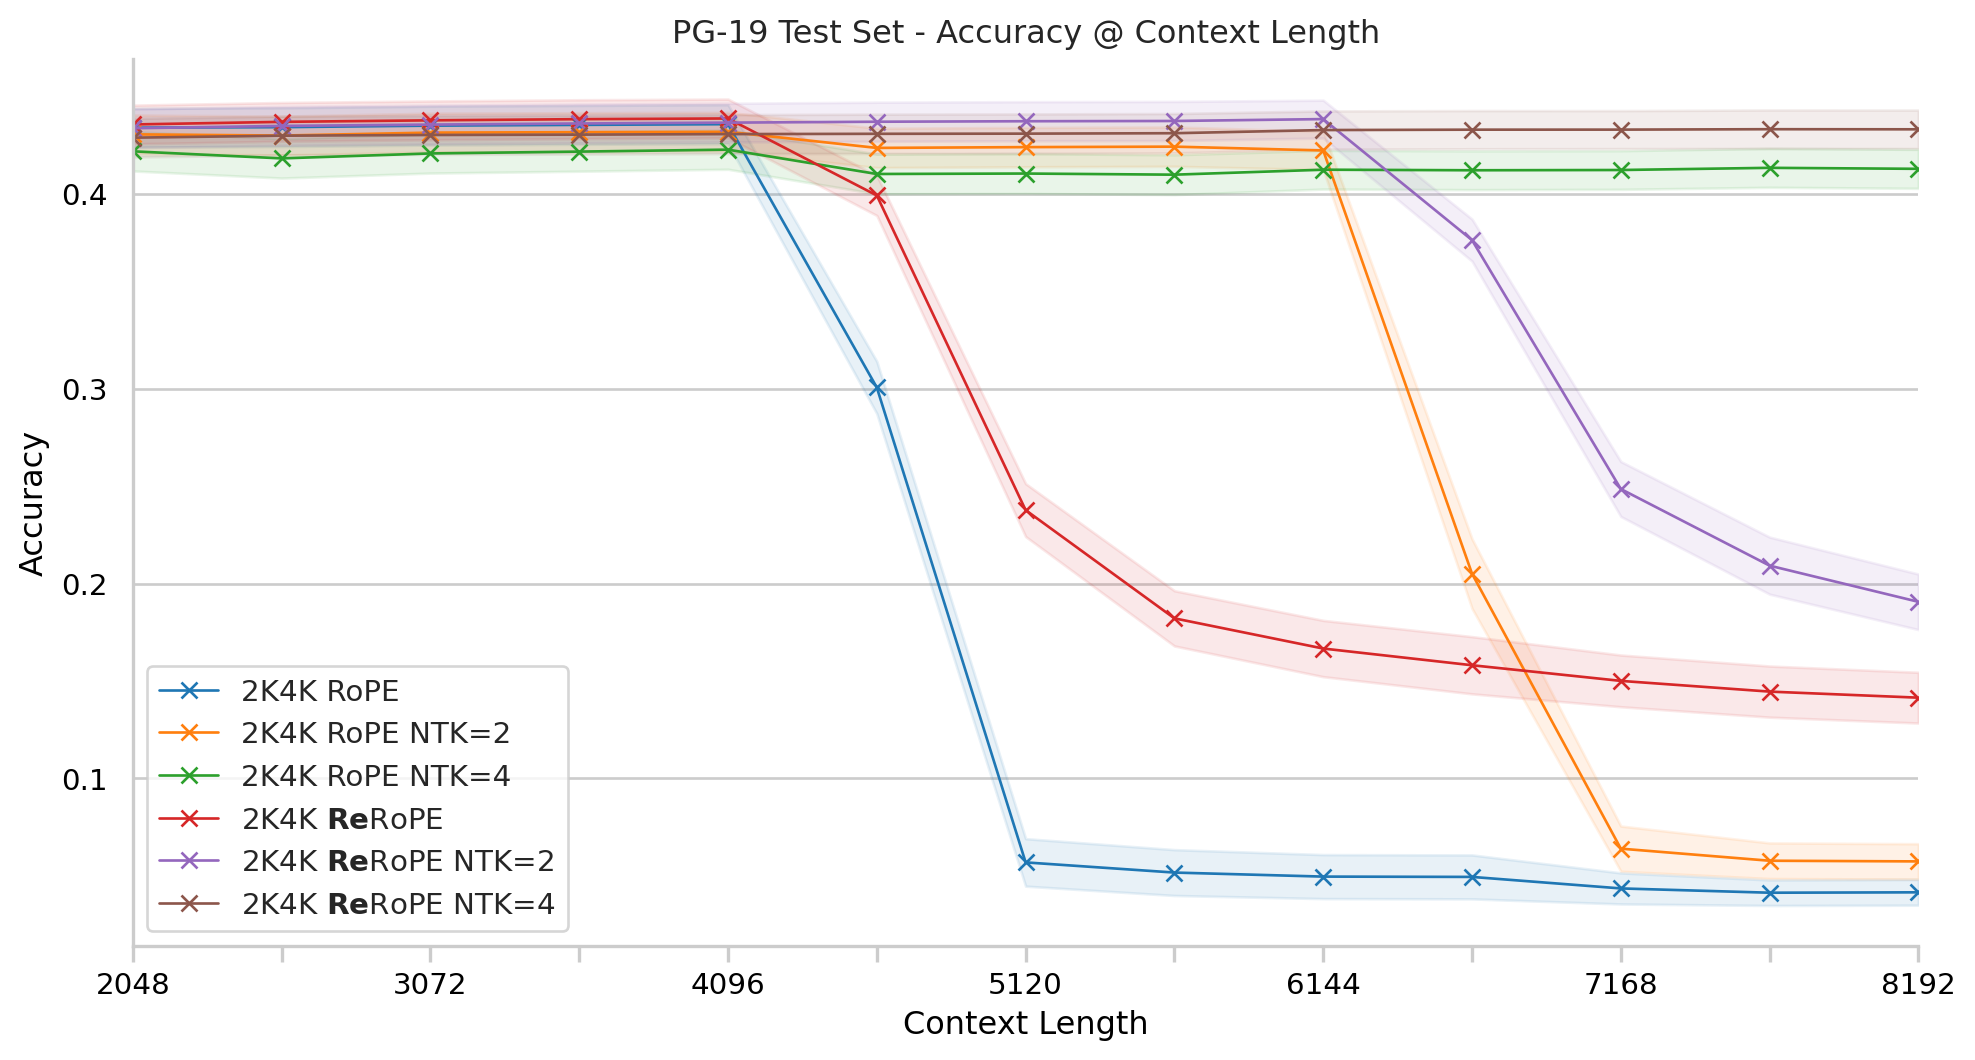

In [14]:
graph_title = 'PG-19 Test Set - {metric} @ Context Length'
print( graph_title )

cont_min = 2048
cont_max = 8192
cont_stride = 512
context_lens = list( range( cont_min, cont_max + 1, cont_stride ) )

dataset_hf = dataset_pg19_t
dataset_name = 'pg19-t'
dataset_key = 'text'

compute_group( dataset_hf, dataset_key, dataset_name, cont_min, cont_max, cont_stride, graph_title )

### Gov Reports

Gov Reports Test Set - {metric} @ Context Length


  0%|                                   | 0/973 [00:00<?, ?it/s]

100%|█████████████████████████| 973/973 [59:52<00:00,  3.69s/it]
/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


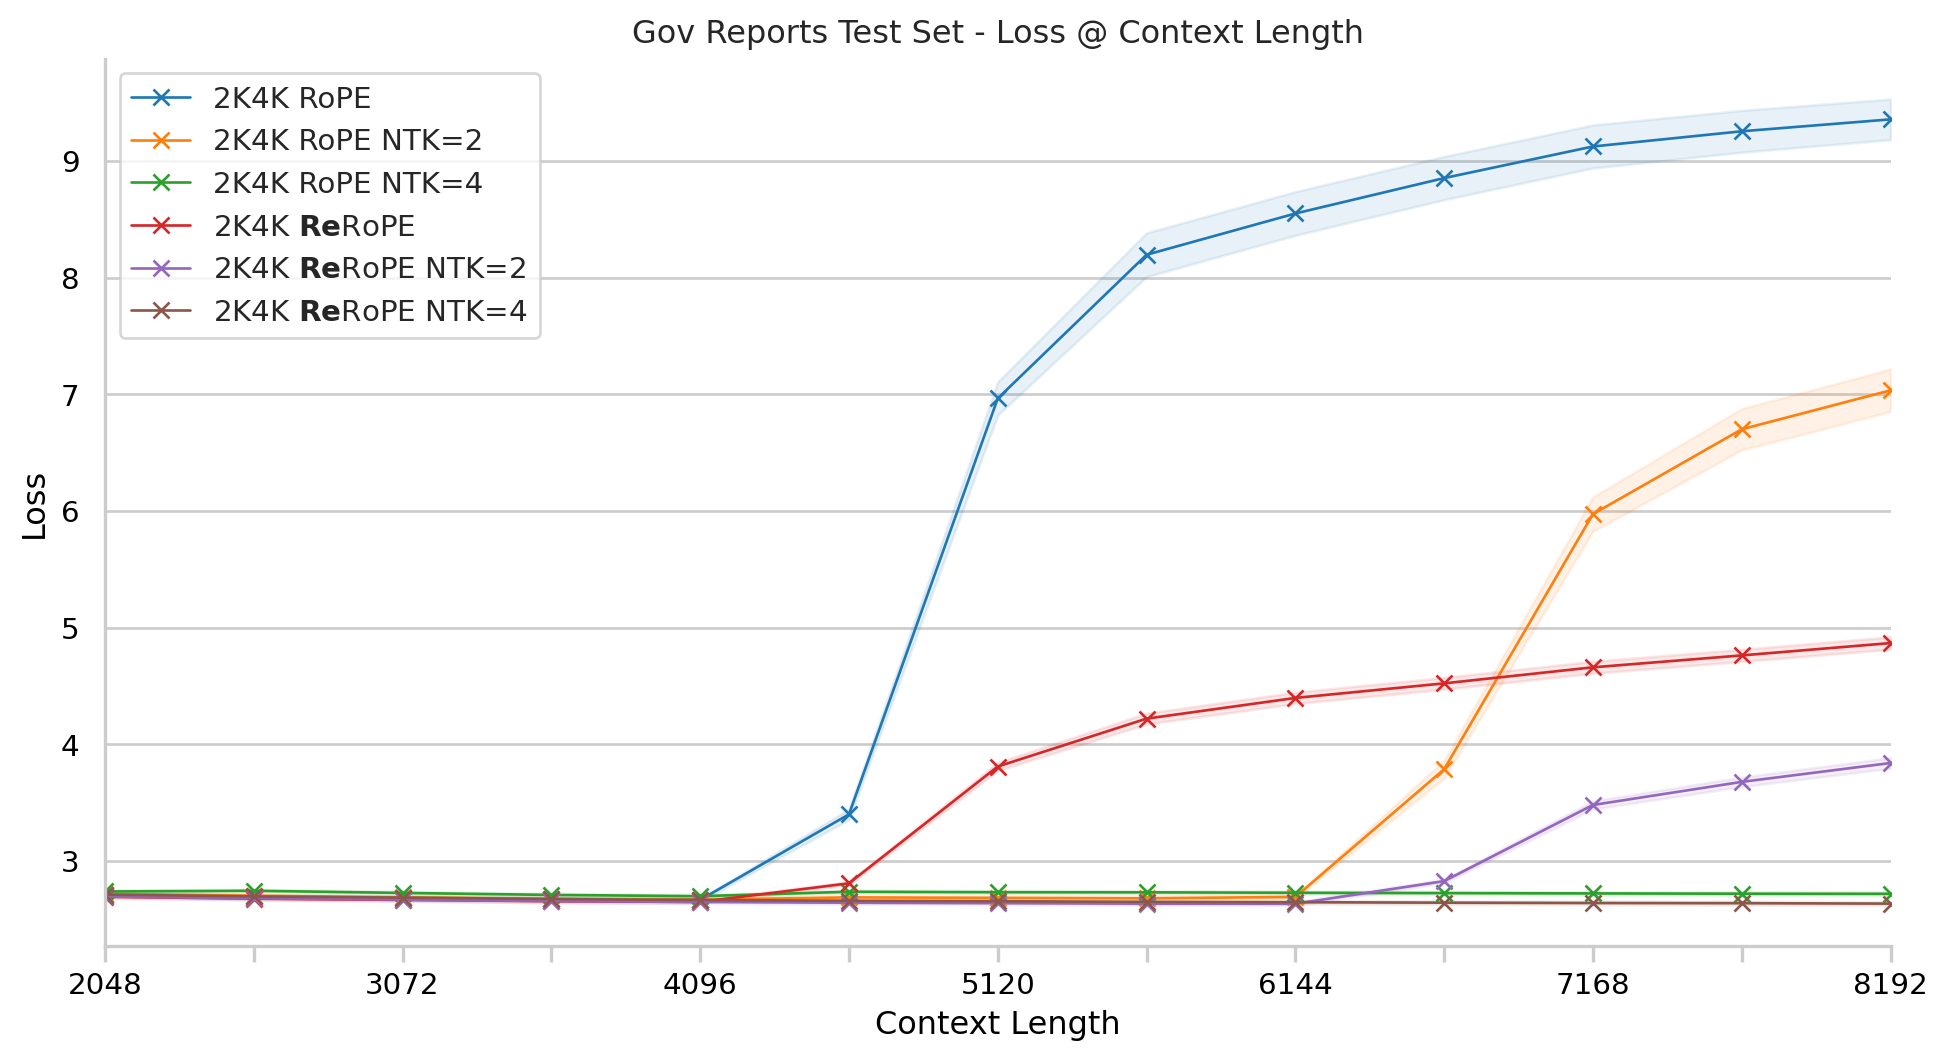

/tmp/ipykernel_12842/818219078.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend( label_names )


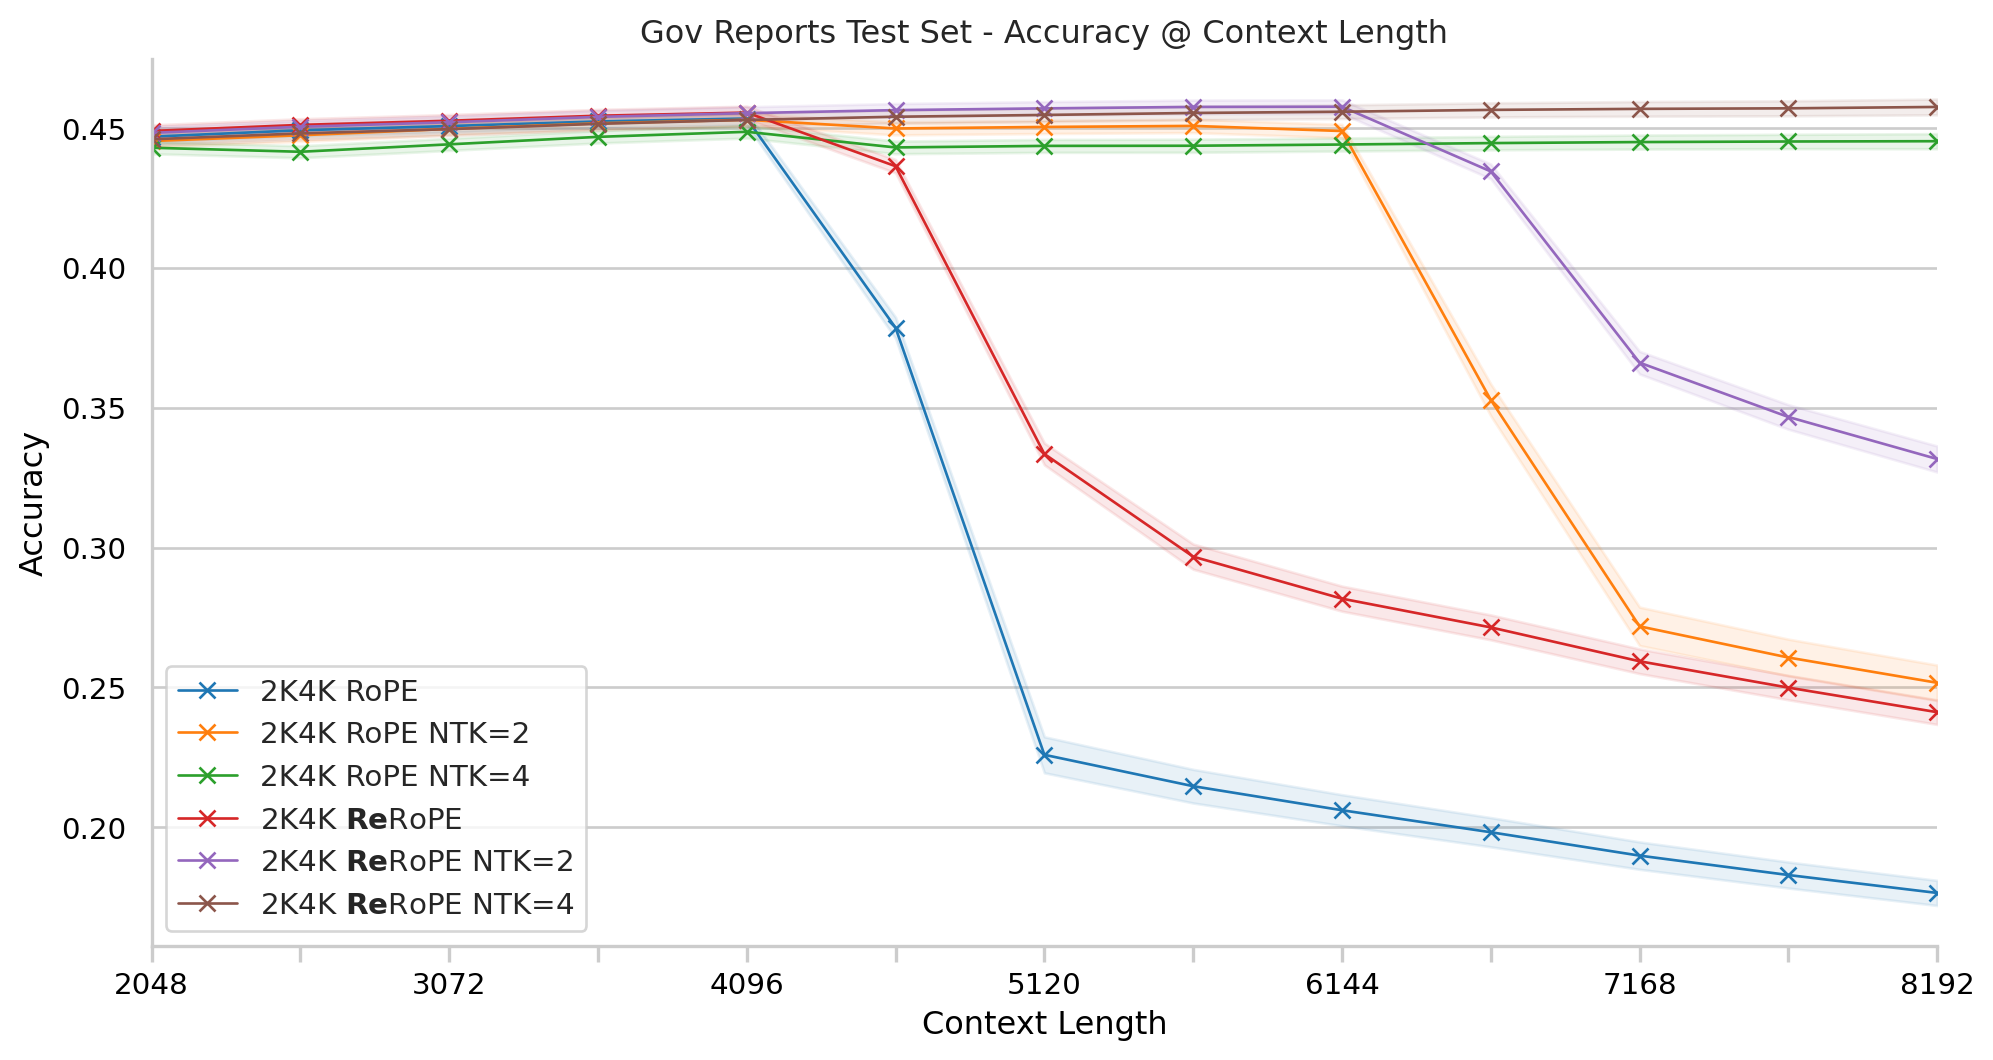

In [15]:
graph_title = 'Gov Reports Test Set - {metric} @ Context Length'
print( graph_title )

cont_min = 2048
cont_max = 8192
cont_stride = 512

dataset_hf = dataset_gov                                                                                                                       
dataset_name = 'gov-t'
dataset_key = 'input'

compute_group( dataset_hf, dataset_key, dataset_name, cont_min, cont_max, cont_stride, graph_title )

## Token Level Experiments

In [16]:
from scipy.ndimage import gaussian_filter1d, uniform_filter1d

def runningMean( x, N, iters=5 ):
    accu_denom = 1
    accu = gaussian_filter1d( x, N, mode='mirror' )
    
    for i in range( 1, iters + 1 ):
        accu += gaussian_filter1d( x, N / ( 2 ** i ), mode='mirror' ) / ( 2 ** i )
        accu_denom += 1 / ( 2 ** i )
    return accu / accu_denom

### Fixed NTK

In [17]:
def do_tok_experiment( dataset: Dataset, key: str, model: LSWTForCausalLM, min_len: int, max_len: int, stride: int, count: int ):
    dataset_len = len( dataset )
    curr_count = 0

    @cache
    def tokenize_example( idx: int ) -> Tuple[ torch.LongTensor, torch.LongTensor, int ]:
        tokens = tokenizer.encode( dataset[idx][key], add_special_tokens=False )
        
        tokens_x = [ tokenizer.bos_token_id ] + tokens
        tokens_y = tokens + [ tokenizer.eos_token_id ]
        
        orig_len = len( tokens_x )        
        tokens_x = torch.LongTensor( [ tokens_x ] )
        tokens_y = torch.LongTensor( [ tokens_y ] )
        
        return tokens_x, tokens_y, orig_len
    
    @torch.no_grad()
    def evaluate(
        tokens_x: torch.LongTensor,
        tokens_y: torch.LongTensor,
        chunk_size: int,
    ):        
        tokens_xs = torch.split( tokens_x.cuda(), chunk_size, dim=1 )
        tokens_ys = torch.split( tokens_y.cuda(), chunk_size, dim=1 )
        
        loss_s = torch.empty( [ 0 ], dtype=torch.float32, device='cuda' )
        
        past_key_values = None

        for tx, ty in zip( tokens_xs, tokens_ys ):
            outputs = model(
                input_ids=tx,
                past_key_values=past_key_values,
                use_cache=True,
                max_key_values=max_len,
            )

            past_key_values = outputs.past_key_values
            logits = outputs.logits.float()
            
            loss = torch.nn.functional.cross_entropy( logits[0], ty[0], reduction='none' )
            loss_s = torch.cat( [ loss_s, loss ] )       
        return loss_s
    
    loss_s = torch.zeros( max_len, dtype=torch.float32, device='cuda' )
    
    iterator = tqdm.tqdm( range( dataset_len ), smoothing=0.0, ncols=64 )
    
    for i in iterator:
        if curr_count >= count and count != 0:
            break
        
        tokens_x, tokens_y, orig_len = tokenize_example( i )
        
        if orig_len < min_len:
            continue
        curr_count += 1
        
        tokens_x = tokens_x[ :, : max_len ]
        tokens_y = tokens_y[ :, : max_len ]
        
        loss_s += evaluate( tokens_x, tokens_y, stride )
        
        print( '', end='', flush=True )
    
    print( curr_count )
    return loss_s / curr_count

In [18]:
tok_2048_loss = do_tok_experiment( dataset_gov, 'input', model_2048, 12288, 12288, 2048, 0 ).cpu().numpy()
tok_2048_loss_re = do_tok_experiment( dataset_gov, 'input', model_2048_re, 12288, 12288, 2048, 0 ).cpu().numpy()

tok_2048_loss_abf2 = do_tok_experiment( dataset_gov, 'input', model_2048_abf2, 12288, 12288, 2048, 0 ).cpu().numpy()
tok_2048_loss_re_abf2 = do_tok_experiment( dataset_gov, 'input', model_2048_re_abf2, 12288, 12288, 2048, 0 ).cpu().numpy()

tok_2048_loss_abf4 = do_tok_experiment( dataset_gov, 'input', model_2048_abf4, 12288, 12288, 2048, 0 ).cpu().numpy()
tok_2048_loss_re_abf4 = do_tok_experiment( dataset_gov, 'input', model_2048_re_abf4, 12288, 12288, 2048, 0 ).cpu().numpy()

100%|█████████████████████████| 973/973 [01:13<00:00, 13.16it/s]


278


100%|█████████████████████████| 973/973 [01:13<00:00, 13.16it/s]


278


100%|█████████████████████████| 973/973 [01:13<00:00, 13.18it/s]


278


100%|█████████████████████████| 973/973 [01:13<00:00, 13.18it/s]


278


100%|█████████████████████████| 973/973 [01:13<00:00, 13.16it/s]


278


100%|█████████████████████████| 973/973 [01:13<00:00, 13.15it/s]

278


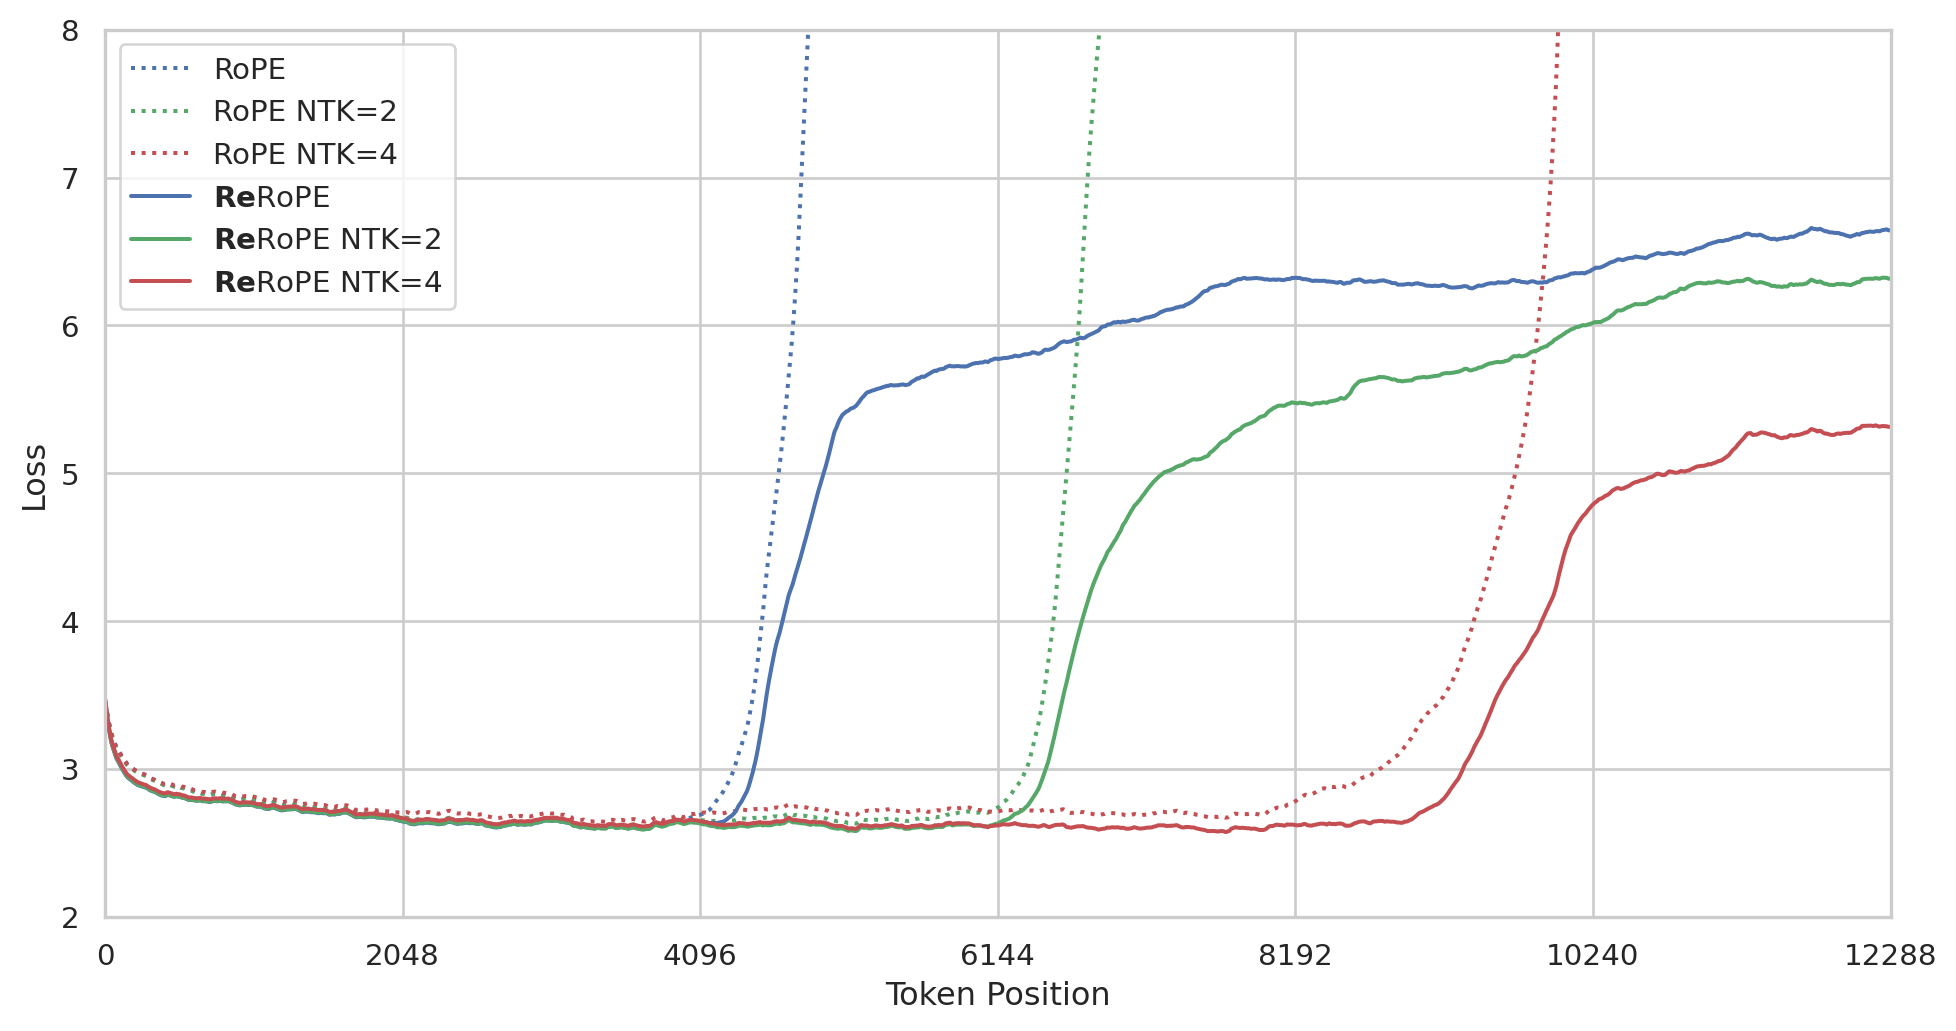

In [37]:
filter_width = 128

plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( ( runningMean( tok_2048_loss, filter_width ) ), color='C0', linestyle='dotted' )
plt.plot( ( runningMean( tok_2048_loss_abf2, filter_width ) ), color='C2', linestyle='dotted' )
plt.plot( ( runningMean( tok_2048_loss_abf4, filter_width ) ), color='C3', linestyle='dotted' )
plt.plot( ( runningMean( tok_2048_loss_re, filter_width ) ), color='C0' )
plt.plot( ( runningMean( tok_2048_loss_re_abf2, filter_width ) ), color='C2' )
plt.plot( ( runningMean( tok_2048_loss_re_abf4, filter_width ) ), color='C3' )

plt.gca().set_ylim( bottom=2, top=8 )
plt.gca().set_xlim( left=0, right=12288 )
plt.gca().xaxis.set_major_locator( ticker.MultipleLocator( 2048 ) )
plt.legend( [ 'RoPE', 'RoPE NTK=2', 'RoPE NTK=4', r'$\bf{Re}$RoPE', r'$\bf{Re}$RoPE NTK=2', r'$\bf{Re}$RoPE NTK=4' ] )
plt.ylabel( 'Loss' )
plt.xlabel( 'Token Position' )
plt.show()

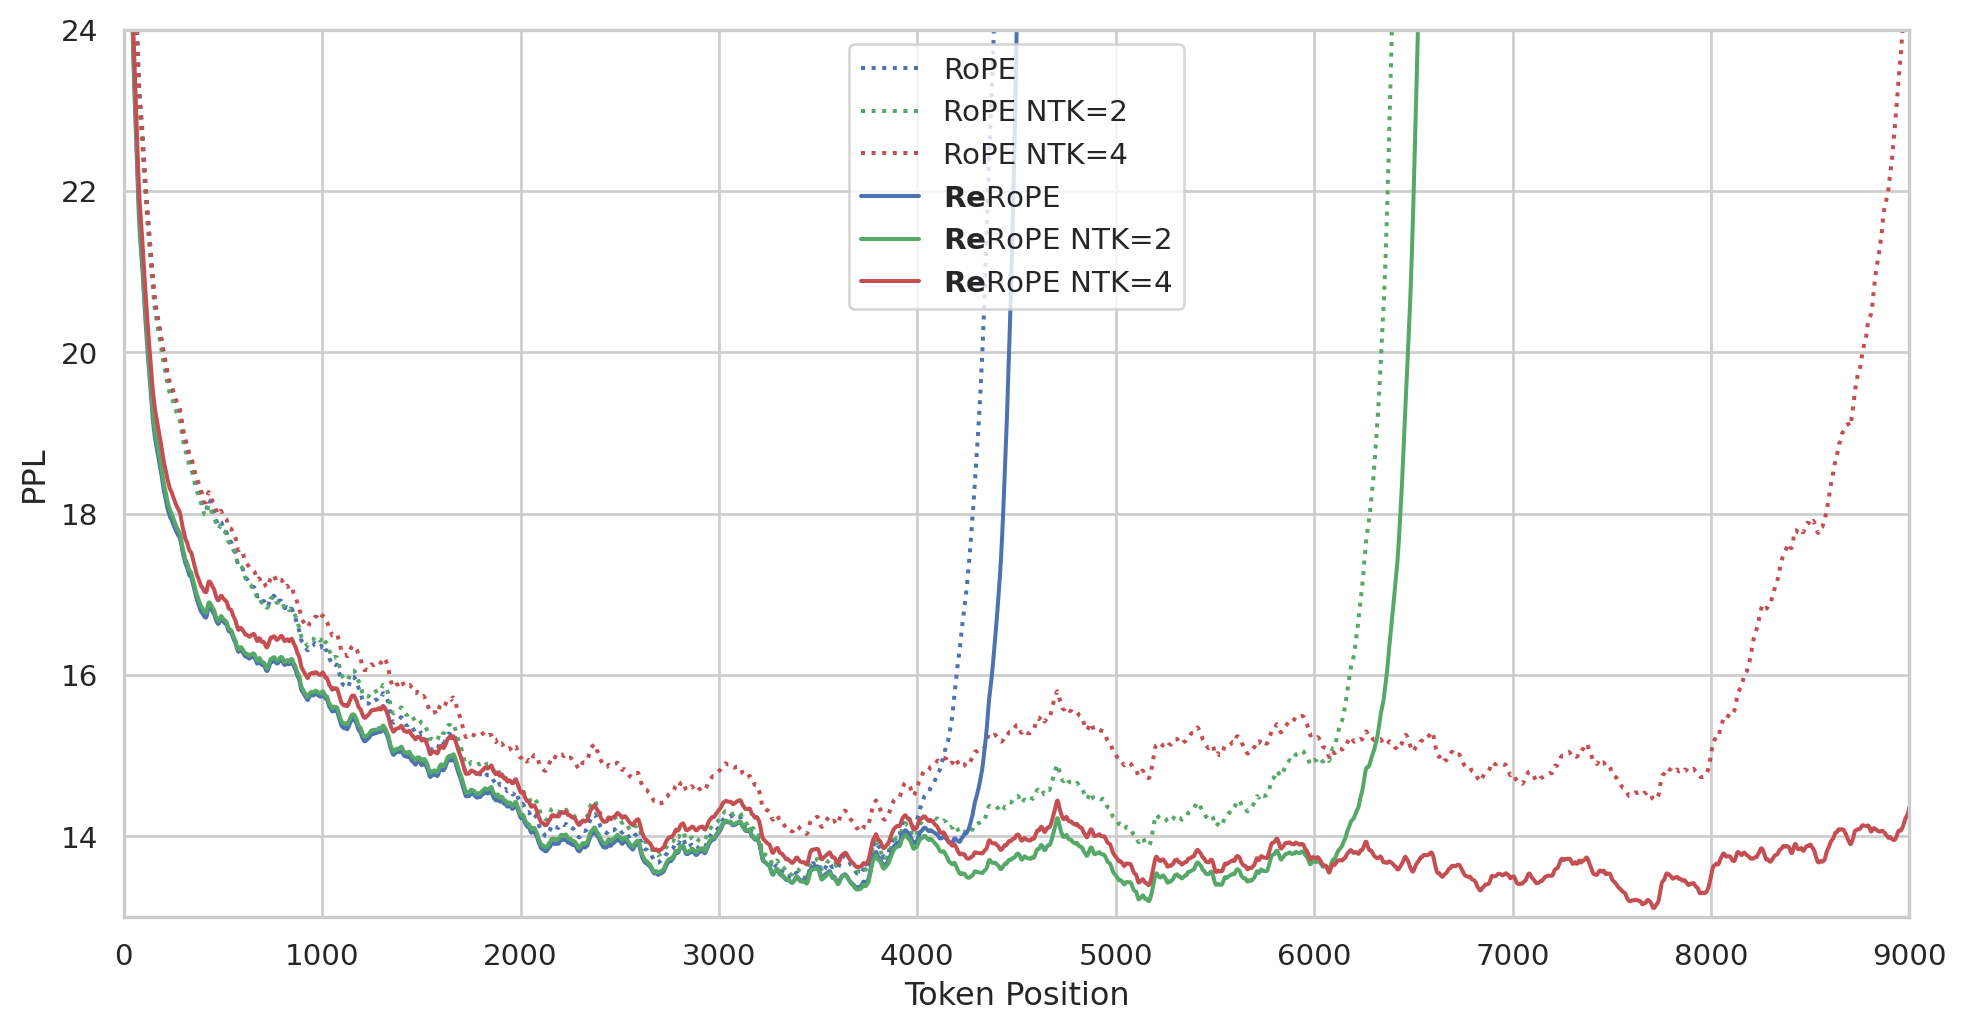

In [38]:
filter_width = 128

plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( np.exp( runningMean( tok_2048_loss, filter_width ) ), color='C0', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_2048_loss_abf2, filter_width ) ), color='C2', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_2048_loss_abf4, filter_width ) ), color='C3', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_2048_loss_re, filter_width ) ), color='C0' )
plt.plot( np.exp( runningMean( tok_2048_loss_re_abf2, filter_width ) ), color='C2' )
plt.plot( np.exp( runningMean( tok_2048_loss_re_abf4, filter_width ) ), color='C3' )

plt.gca().set_ylim( bottom=13, top=24 )
plt.gca().set_xlim( left=0, right=9000 )
plt.legend( [ 'RoPE', 'RoPE NTK=2', 'RoPE NTK=4', r'$\bf{Re}$RoPE', r'$\bf{Re}$RoPE NTK=2', r'$\bf{Re}$RoPE NTK=4' ] )
plt.ylabel( 'PPL' )
plt.xlabel( 'Token Position' )
plt.show()

In [21]:
tok_1024_loss = do_tok_experiment( dataset_gov, 'input', model_1024, 6144, 6144, 1024, 0 ).cpu().numpy()
tok_1024_loss_re = do_tok_experiment( dataset_gov, 'input', model_1024_re, 6144, 6144, 1024, 0 ).cpu().numpy()

tok_1024_loss_abf2 = do_tok_experiment( dataset_gov, 'input', model_1024_abf2, 6144, 6144, 1024, 0 ).cpu().numpy()
tok_1024_loss_re_abf2 = do_tok_experiment( dataset_gov, 'input', model_1024_re_abf2, 6144, 6144, 1024, 0 ).cpu().numpy()

tok_1024_loss_abf4 = do_tok_experiment( dataset_gov, 'input', model_1024_abf4, 6144, 6144, 1024, 0 ).cpu().numpy()
tok_1024_loss_re_abf4 = do_tok_experiment( dataset_gov, 'input', model_1024_re_abf4, 6144, 6144, 1024, 0 ).cpu().numpy()

100%|█████████████████████████| 973/973 [01:27<00:00, 11.18it/s]


706


100%|█████████████████████████| 973/973 [01:27<00:00, 11.18it/s]


706


100%|█████████████████████████| 973/973 [01:27<00:00, 11.18it/s]


706


100%|█████████████████████████| 973/973 [01:27<00:00, 11.18it/s]


706


100%|█████████████████████████| 973/973 [01:26<00:00, 11.22it/s]


706


100%|█████████████████████████| 973/973 [01:26<00:00, 11.22it/s]

706


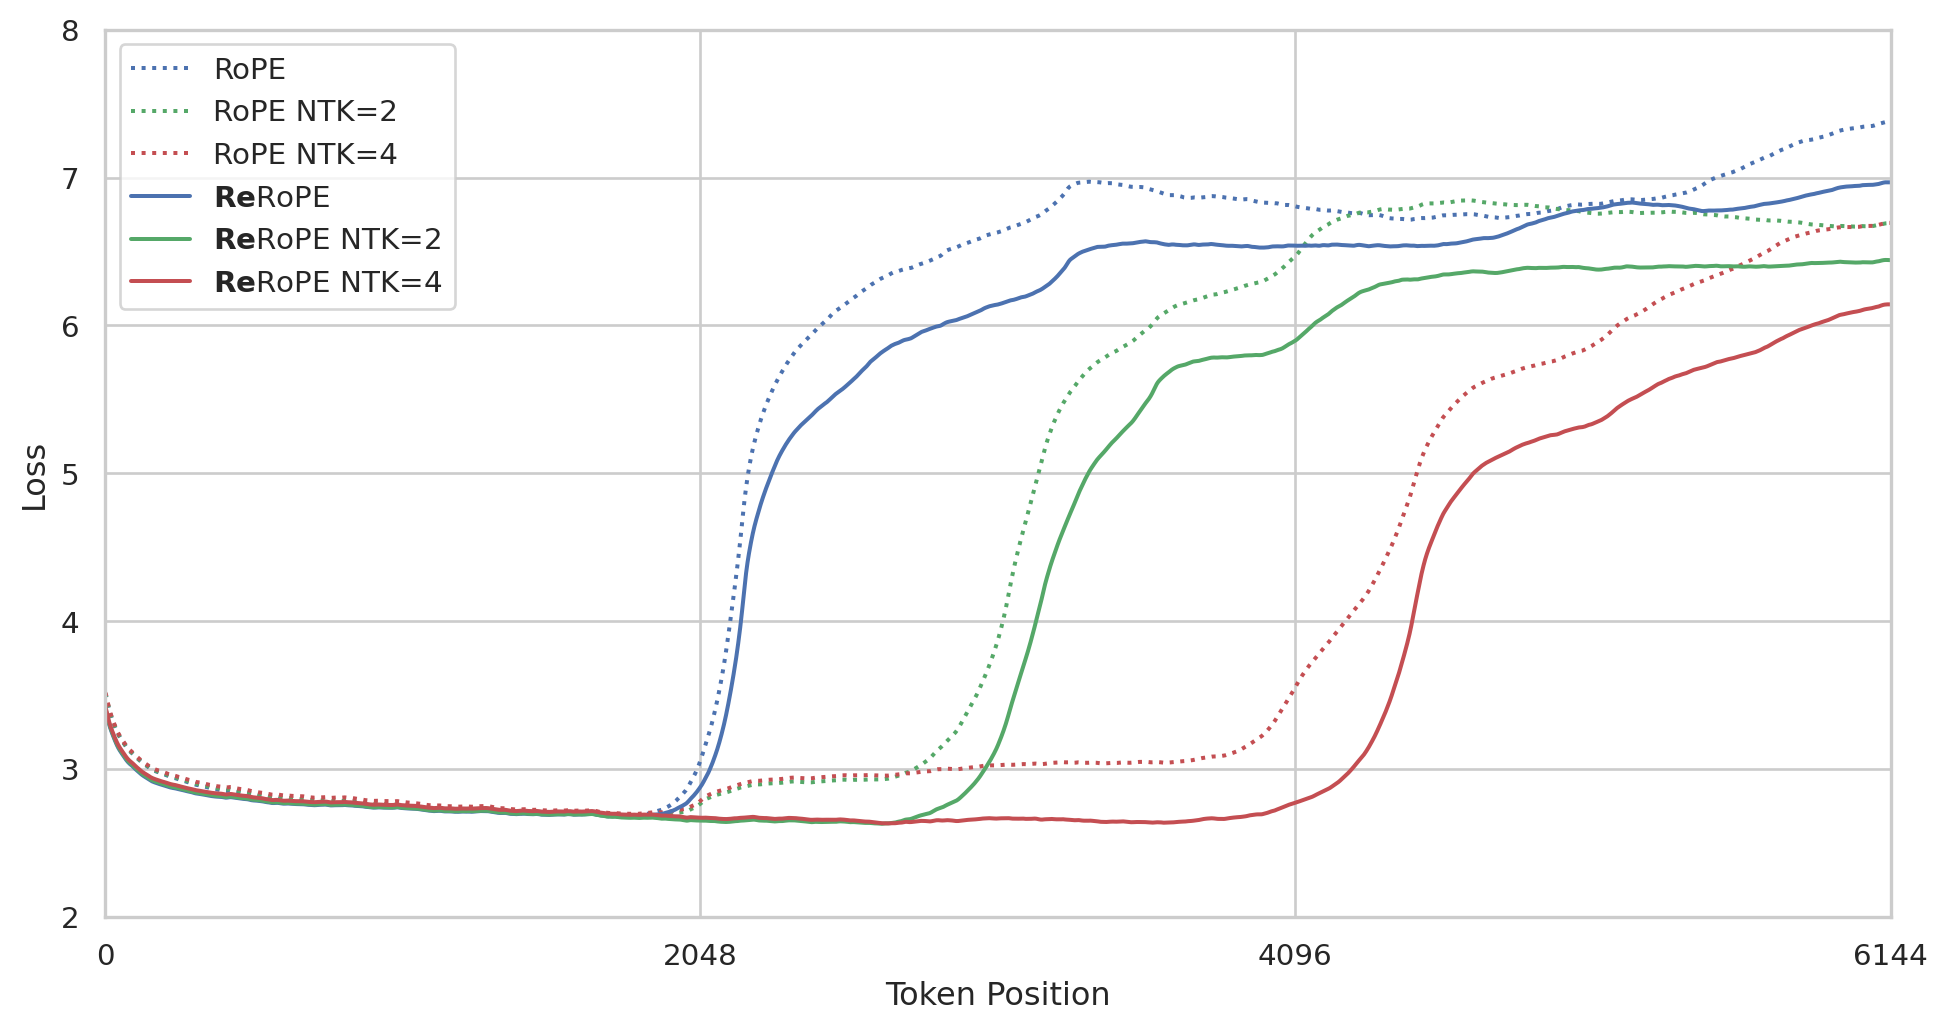

In [39]:
plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( ( runningMean( tok_1024_loss, 128 ) ), color='C0', linestyle='dotted' )
plt.plot( ( runningMean( tok_1024_loss_abf2, 128 ) ), color='C2', linestyle='dotted' )
plt.plot( ( runningMean( tok_1024_loss_abf4, 128 ) ), color='C3', linestyle='dotted' )
plt.plot( ( runningMean( tok_1024_loss_re, 128 ) ), color='C0' )
plt.plot( ( runningMean( tok_1024_loss_re_abf2, 128 ) ), color='C2' )
plt.plot( ( runningMean( tok_1024_loss_re_abf4, 128 ) ), color='C3' )

plt.gca().set_ylim( bottom=2, top=8 )
plt.gca().set_xlim( left=0, right=6144 )
plt.gca().xaxis.set_major_locator( ticker.MultipleLocator( 2048 ) )
plt.legend( [ 'RoPE', 'RoPE NTK=2', 'RoPE NTK=4', r'$\bf{Re}$RoPE', r'$\bf{Re}$RoPE NTK=2', r'$\bf{Re}$RoPE NTK=4' ] )
plt.ylabel( 'Loss' )
plt.xlabel( 'Token Position' )
plt.show()

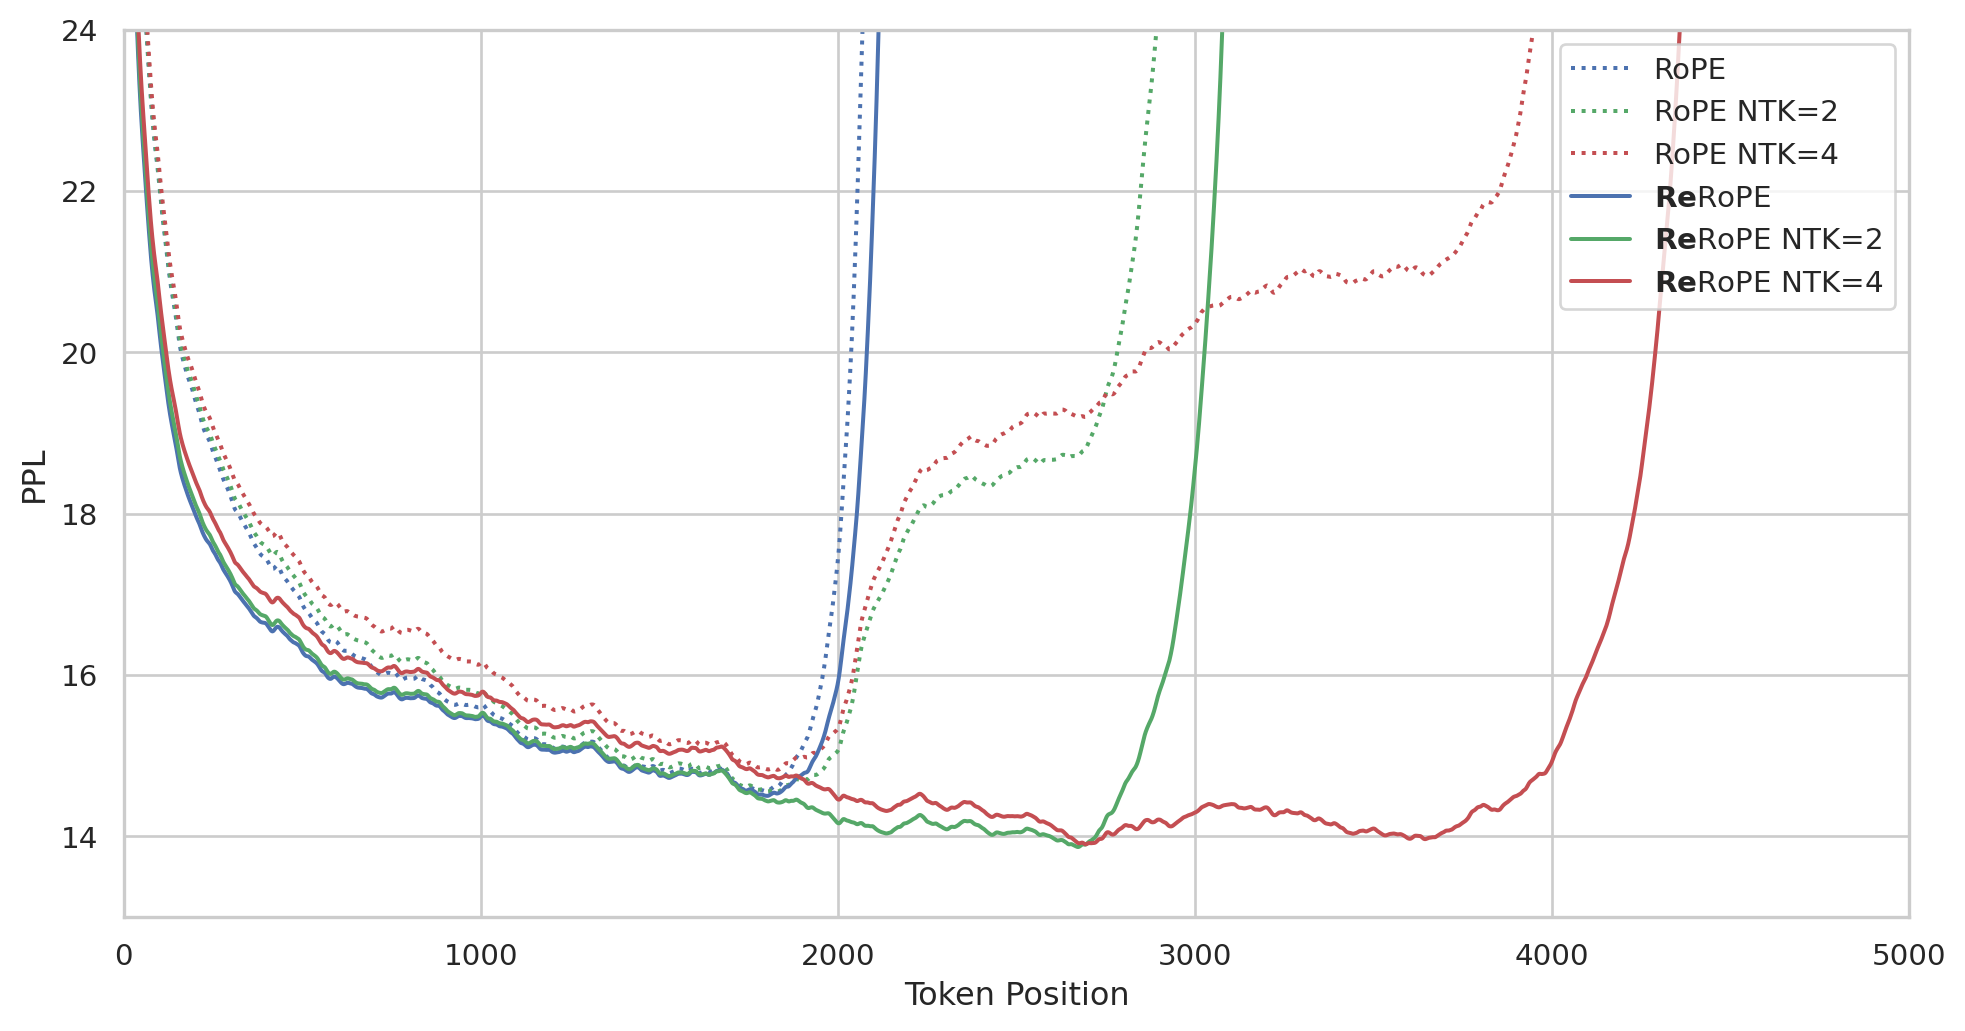

In [40]:
plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( np.exp( runningMean( tok_1024_loss, 128 ) ), color='C0', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_1024_loss_abf2, 128 ) ), color='C2', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_1024_loss_abf4, 128 ) ), color='C3', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_1024_loss_re, 128 ) ), color='C0' )
plt.plot( np.exp( runningMean( tok_1024_loss_re_abf2, 128 ) ), color='C2' )
plt.plot( np.exp( runningMean( tok_1024_loss_re_abf4, 128 ) ), color='C3' )

plt.gca().set_ylim( bottom=13, top=24 )
plt.gca().set_xlim( left=0, right=5000 )
plt.legend( [ 'RoPE', 'RoPE NTK=2', 'RoPE NTK=4', r'$\bf{Re}$RoPE', r'$\bf{Re}$RoPE NTK=2', r'$\bf{Re}$RoPE NTK=4' ] )
plt.ylabel( 'PPL' )
plt.xlabel( 'Token Position' )
plt.show()

### Dynamic NTK

In [24]:
def do_tok_experiment_dynamic( dataset: Dataset, key: str, model: LSWTForCausalLM, min_len: int, max_len: int, stride: int, count: int, base: int ):
    dataset_len = len( dataset )
    curr_count = 0

    @cache
    def tokenize_example( idx: int ) -> Tuple[ torch.LongTensor, torch.LongTensor, int ]:
        tokens = tokenizer.encode( dataset[idx][key], add_special_tokens=False )
        
        tokens_x = [ tokenizer.bos_token_id ] + tokens
        tokens_y = tokens + [ tokenizer.eos_token_id ]
        
        orig_len = len( tokens_x )        
        tokens_x = torch.LongTensor( [ tokens_x ] )
        tokens_y = torch.LongTensor( [ tokens_y ] )
        
        return tokens_x, tokens_y, orig_len
    
    @torch.no_grad()
    def evaluate(
        tokens_x: torch.LongTensor,
        tokens_y: torch.LongTensor,
        chunk_size: int,
    ):        
        tokens_xs = torch.split( tokens_x.cuda(), chunk_size, dim=1 )
        tokens_ys = torch.split( tokens_y.cuda(), chunk_size, dim=1 )
        
        loss_s = torch.empty( [ 0 ], dtype=torch.float32, device='cuda' )
        
        past_key_values = None
        
        

        for i, ( tx, ty ) in enumerate( zip( tokens_xs, tokens_ys ) ):
            cur_len = ( i + 1 ) * chunk_size
            
            model.config.rope_ntk_scale = max( 1.0, cur_len / base ) ** 2
            model.config.rope_yarn_scale = max( 1.0, cur_len / base )
            model.model.rope_embedding = RotaryEmbedding(
                model.config.d_model // model.config.n_heads,
                model.config.rope_xpos_scale,
                model.config.rope_xpos_enabled,
                model.config.rope_base_freq,
                model.config.rope_reversed,
                model.config.rope_ntk_scale,
            ).cuda()
            
            outputs = model(
                input_ids=tx,
                past_key_values=past_key_values,
                use_cache=True,
                max_key_values=max_len,
            )

            past_key_values = outputs.past_key_values
            logits = outputs.logits.float()
            
            loss = torch.nn.functional.cross_entropy( logits[0], ty[0], reduction='none' )
            loss_s = torch.cat( [ loss_s, loss ] )       
        return loss_s
    
    loss_s = torch.zeros( max_len, dtype=torch.float32, device='cuda' )
    
    iterator = tqdm.tqdm( range( dataset_len ), smoothing=0.0, ncols=64 )
    
    for i in iterator:
        if curr_count >= count and count != 0:
            break
        
        tokens_x, tokens_y, orig_len = tokenize_example( i )
        
        if orig_len < min_len:
            continue
        curr_count += 1
        
        tokens_x = tokens_x[ :, : max_len ]
        tokens_y = tokens_y[ :, : max_len ]
        
        loss_s += evaluate( tokens_x, tokens_y, stride )
        
        print( '', end='', flush=True )
    
    print( curr_count )
    return loss_s / curr_count

In [25]:
model_2048_re_dyn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048_re, rope_yarn_a=0.00 ) ).half().cuda().eval()
model_2048_dyn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048, rope_yarn_a=0.00 ) ).half().cuda().eval()

model_2048_re_yarn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048_re, rope_yarn_a=0.07 ) ).half().cuda().eval()
model_2048_yarn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048, rope_yarn_a=0.07 ) ).half().cuda().eval()

model_2048_re_yarn2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048_re, rope_yarn_a=0.1 ) ).half().cuda().eval()
model_2048_yarn2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_2048, rope_yarn_a=0.1 ) ).half().cuda().eval()

e_length = 4096 * 4
num_ex = 0

tok_2048_loss_dyn = do_tok_experiment_dynamic( dataset_gov, 'input', model_2048_dyn, e_length, e_length, 2048, num_ex, 4096 ).cpu().numpy()
tok_2048_loss_re_dyn = do_tok_experiment_dynamic( dataset_gov, 'input', model_2048_re_dyn, e_length, e_length, 2048, num_ex, 4096 ).cpu().numpy()
tok_2048_loss_yarn = do_tok_experiment_dynamic( dataset_gov, 'input', model_2048_yarn, e_length, e_length, 2048, num_ex, 4096 ).cpu().numpy()
tok_2048_loss_re_yarn = do_tok_experiment_dynamic( dataset_gov, 'input', model_2048_re_yarn, e_length, e_length, 2048, num_ex, 4096 ).cpu().numpy()
tok_2048_loss_yarn2 = do_tok_experiment_dynamic( dataset_gov, 'input', model_2048_yarn2, e_length, e_length, 2048, num_ex, 4096 ).cpu().numpy()
tok_2048_loss_re_yarn2 = do_tok_experiment_dynamic( dataset_gov, 'input', model_2048_re_yarn2, e_length, e_length, 2048, num_ex, 4096 ).cpu().numpy()

100%|█████████████████████████| 973/973 [01:08<00:00, 14.20it/s]


124


100%|█████████████████████████| 973/973 [01:08<00:00, 14.13it/s]


124


100%|█████████████████████████| 973/973 [01:09<00:00, 14.04it/s]


124


100%|█████████████████████████| 973/973 [01:09<00:00, 14.05it/s]


124


100%|█████████████████████████| 973/973 [01:09<00:00, 14.05it/s]


124


100%|█████████████████████████| 973/973 [01:09<00:00, 14.02it/s]

124


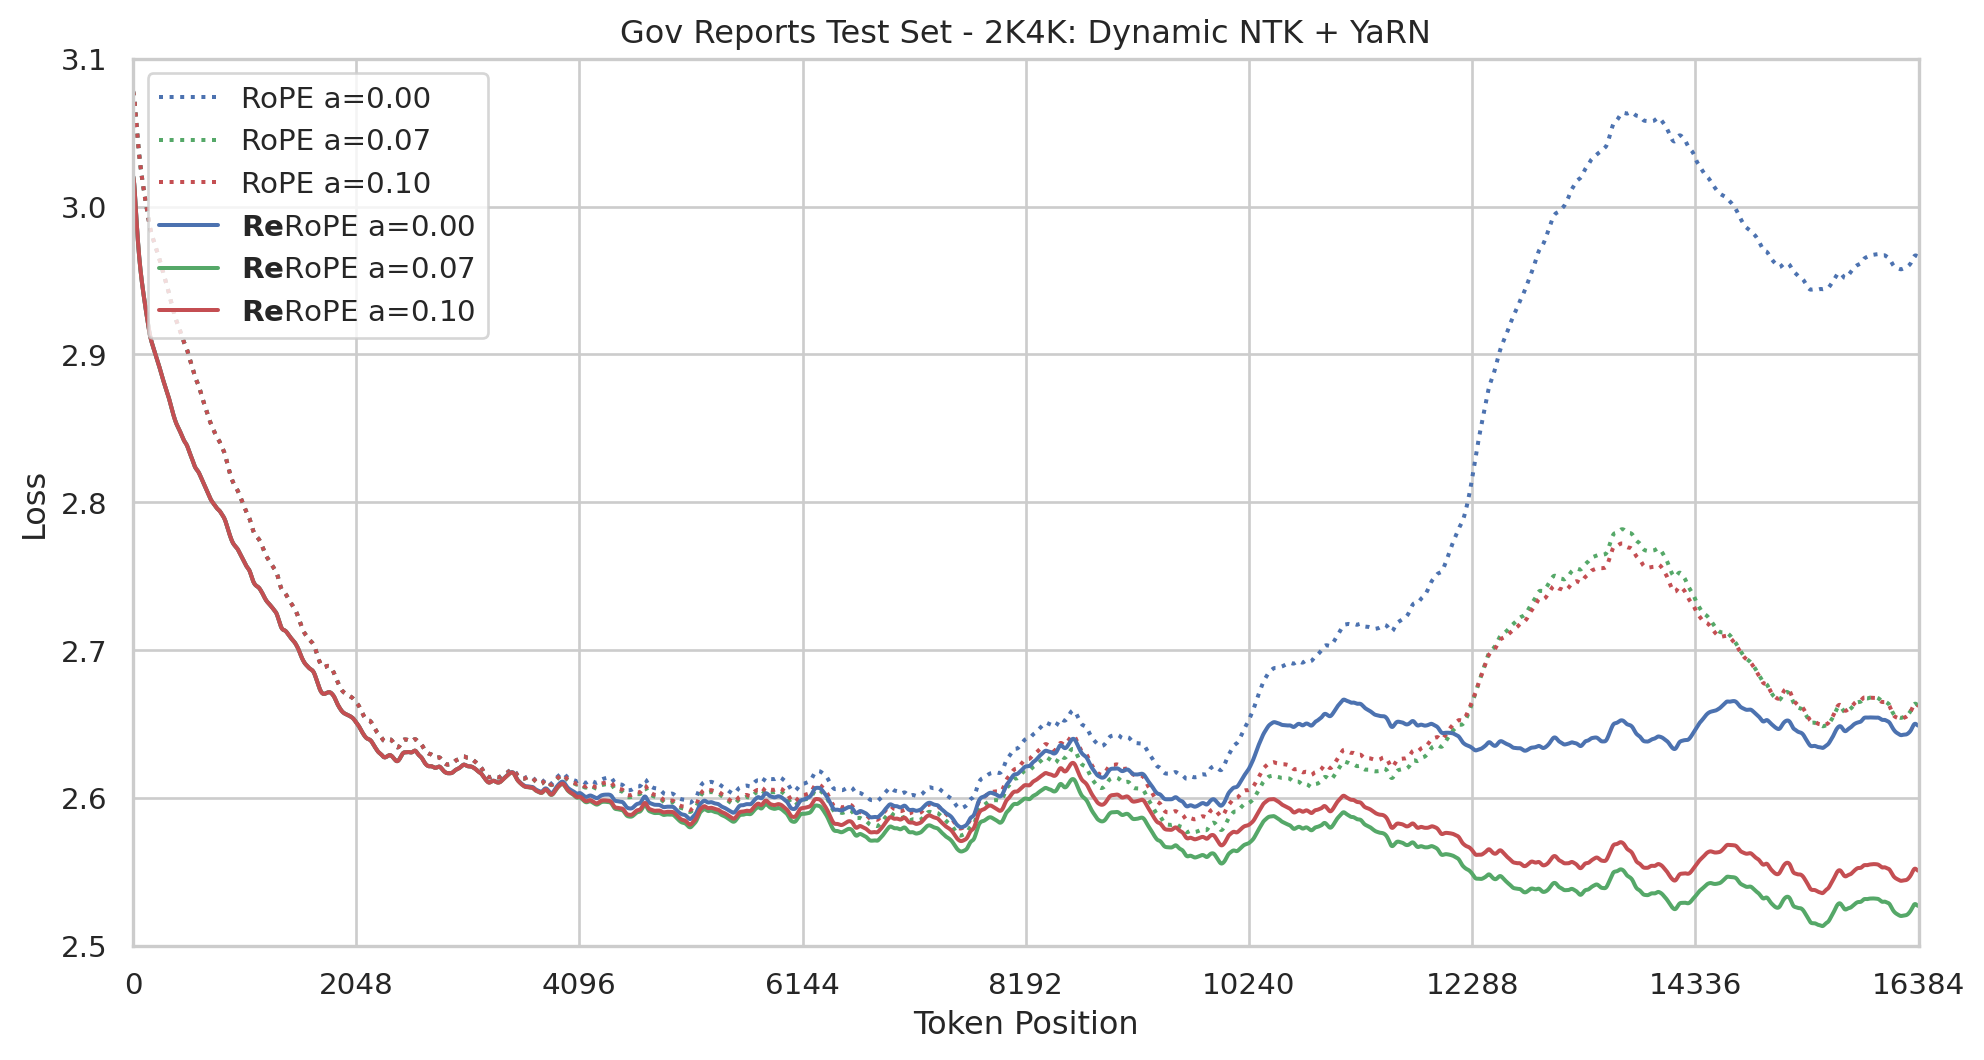

In [26]:
filter_width = 512

plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( ( runningMean( tok_2048_loss_dyn, filter_width ) ), color='C0', linestyle='dotted' )
plt.plot( ( runningMean( tok_2048_loss_yarn, filter_width ) ), color='C2', linestyle='dotted' )
plt.plot( ( runningMean( tok_2048_loss_yarn2, filter_width ) ), color='C3', linestyle='dotted' )

plt.plot( ( runningMean( tok_2048_loss_re_dyn, filter_width ) ), color='C0' )
plt.plot( ( runningMean( tok_2048_loss_re_yarn, filter_width ) ), color='C2' )
plt.plot( ( runningMean( tok_2048_loss_re_yarn2, filter_width ) ), color='C3' )

plt.gca().set_ylim( bottom=2.5, top=3.1 )
plt.gca().set_xlim( left=0, right=e_length )
plt.gca().xaxis.set_major_locator( ticker.MultipleLocator( 2048 ) )
plt.title( 'Gov Reports Test Set - 2K4K: Dynamic NTK + YaRN' )
plt.legend( [ 'RoPE a=0.00',  'RoPE a=0.07', 'RoPE a=0.10', r'$\bf{Re}$RoPE a=0.00', r'$\bf{Re}$RoPE a=0.07', r'$\bf{Re}$RoPE a=0.10' ], loc='upper left' )
plt.ylabel( 'Loss' )
plt.xlabel( 'Token Position' )
plt.show()

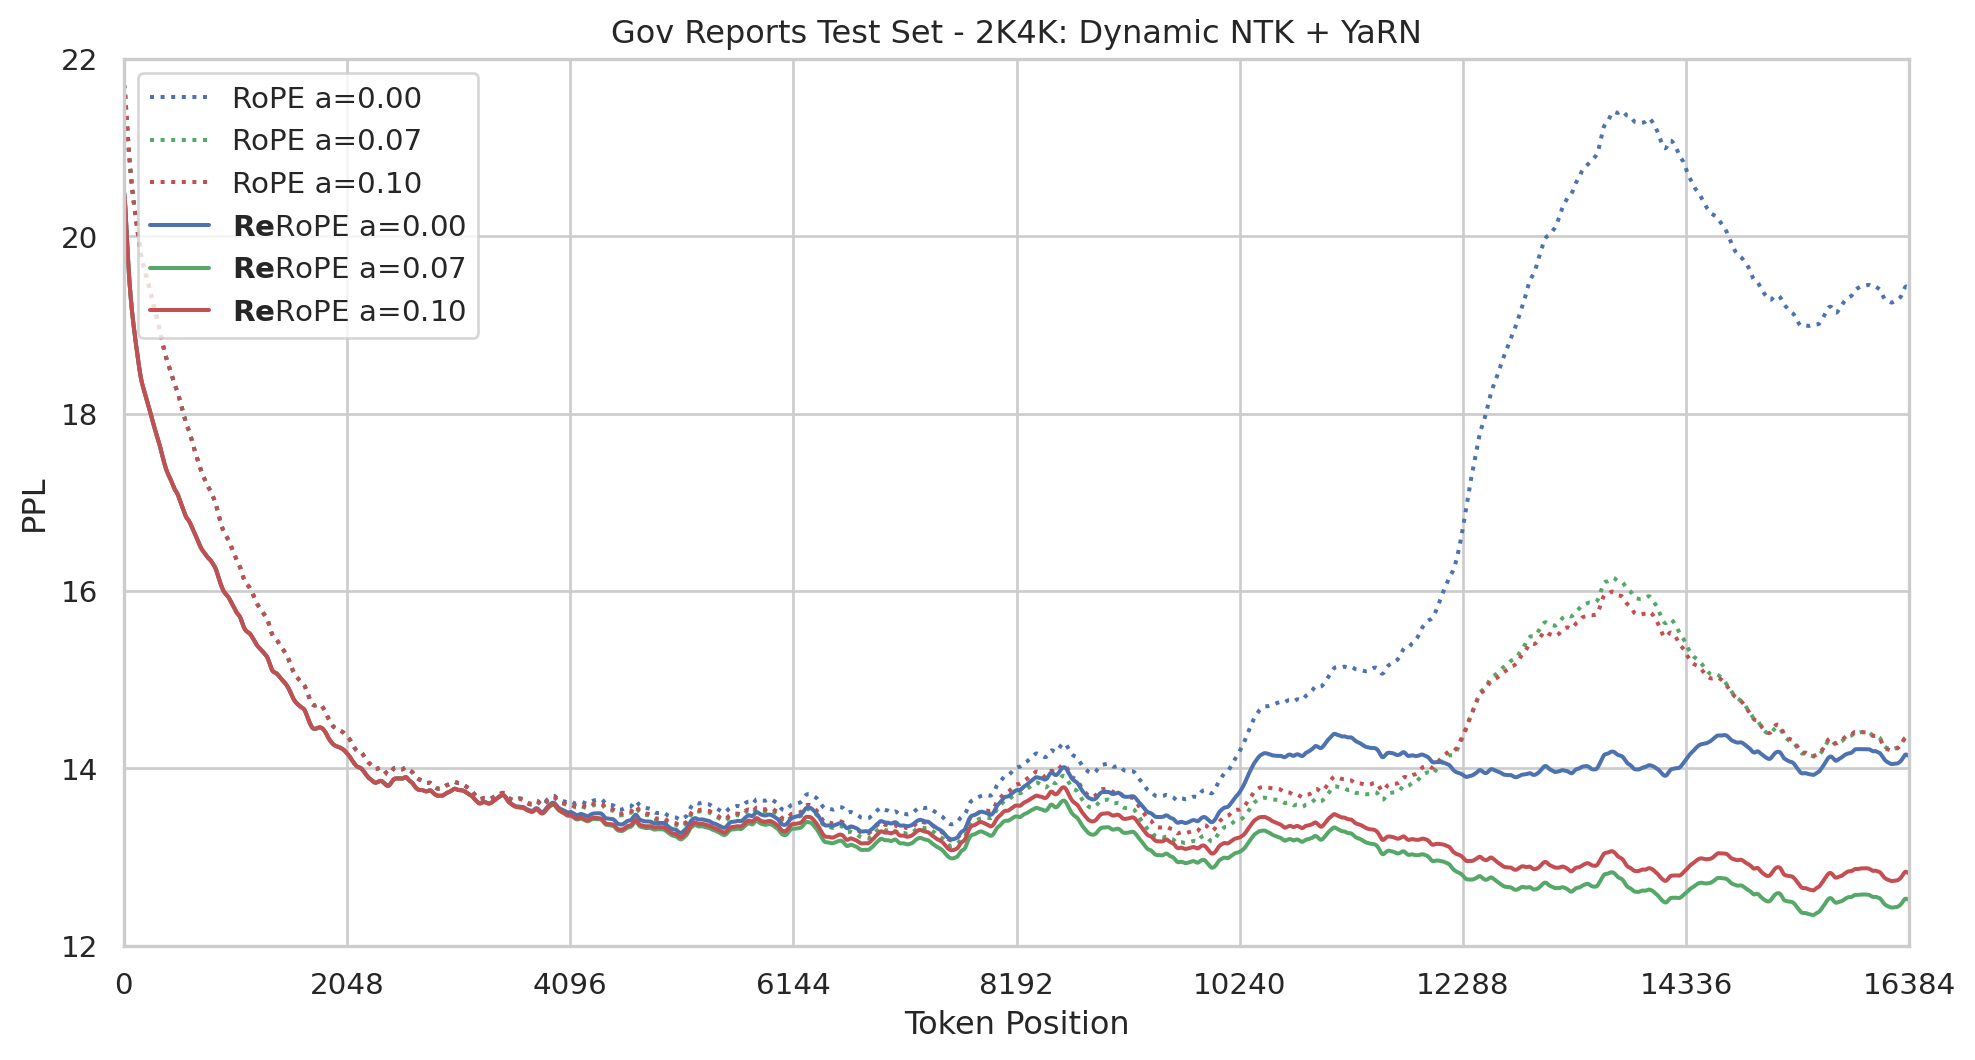

In [27]:
filter_width = 512

plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( np.exp( runningMean( tok_2048_loss_dyn, filter_width ) ), color='C0', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_2048_loss_yarn, filter_width ) ), color='C2', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_2048_loss_yarn2, filter_width ) ), color='C3', linestyle='dotted' )

plt.plot( np.exp( runningMean( tok_2048_loss_re_dyn, filter_width ) ), color='C0' )
plt.plot( np.exp( runningMean( tok_2048_loss_re_yarn, filter_width ) ), color='C2' )
plt.plot( np.exp( runningMean( tok_2048_loss_re_yarn2, filter_width ) ), color='C3' )

plt.gca().set_ylim( bottom=12, top=22 )
plt.gca().set_xlim( left=0, right=e_length )
plt.gca().xaxis.set_major_locator( ticker.MultipleLocator( 2048 ) )
plt.title( 'Gov Reports Test Set - 2K4K: Dynamic NTK + YaRN' )
plt.legend( [ 'RoPE a=0.00',  'RoPE a=0.07', 'RoPE a=0.10', r'$\bf{Re}$RoPE a=0.00', r'$\bf{Re}$RoPE a=0.07', r'$\bf{Re}$RoPE a=0.10' ], loc='upper left' )
plt.ylabel( 'PPL' )
plt.xlabel( 'Token Position' )
plt.show()

In [28]:
model_1024_re_dyn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024_re, rope_yarn_a=0.00 ) ).half().cuda().eval()
model_1024_dyn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024, rope_yarn_a=0.00 ) ).half().cuda().eval()

model_1024_re_yarn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024_re, rope_yarn_a=0.07 ) ).half().cuda().eval()
model_1024_yarn = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024, rope_yarn_a=0.07 ) ).half().cuda().eval()

model_1024_re_yarn2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024_re, rope_yarn_a=0.1 ) ).half().cuda().eval()
model_1024_yarn2 = cast( LSWTForCausalLM, LSWTForCausalLM.from_pretrained( path_1024, rope_yarn_a=0.1 ) ).half().cuda().eval()

e_length = 4096 * 4
num_ex = 0

tok_1024_loss_dyn = do_tok_experiment_dynamic( dataset_gov, 'input', model_1024_dyn, e_length, e_length, 1024, num_ex, 2048 ).cpu().numpy()
tok_1024_loss_re_dyn = do_tok_experiment_dynamic( dataset_gov, 'input', model_1024_re_dyn, e_length, e_length, 1024, num_ex, 2048 ).cpu().numpy()
tok_1024_loss_yarn = do_tok_experiment_dynamic( dataset_gov, 'input', model_1024_yarn, e_length, e_length, 1024, num_ex, 2048 ).cpu().numpy()
tok_1024_loss_re_yarn = do_tok_experiment_dynamic( dataset_gov, 'input', model_1024_re_yarn, e_length, e_length, 1024, num_ex, 2048 ).cpu().numpy()
tok_1024_loss_yarn2 = do_tok_experiment_dynamic( dataset_gov, 'input', model_1024_yarn2, e_length, e_length, 1024, num_ex, 2048 ).cpu().numpy()
tok_1024_loss_re_yarn2 = do_tok_experiment_dynamic( dataset_gov, 'input', model_1024_re_yarn2, e_length, e_length, 1024, num_ex, 2048 ).cpu().numpy()

100%|█████████████████████████| 973/973 [01:25<00:00, 11.39it/s]


124


100%|█████████████████████████| 973/973 [01:25<00:00, 11.44it/s]


124


100%|█████████████████████████| 973/973 [01:26<00:00, 11.28it/s]


124


100%|█████████████████████████| 973/973 [01:26<00:00, 11.28it/s]


124


100%|█████████████████████████| 973/973 [01:26<00:00, 11.25it/s]


124


100%|█████████████████████████| 973/973 [01:26<00:00, 11.23it/s]

124


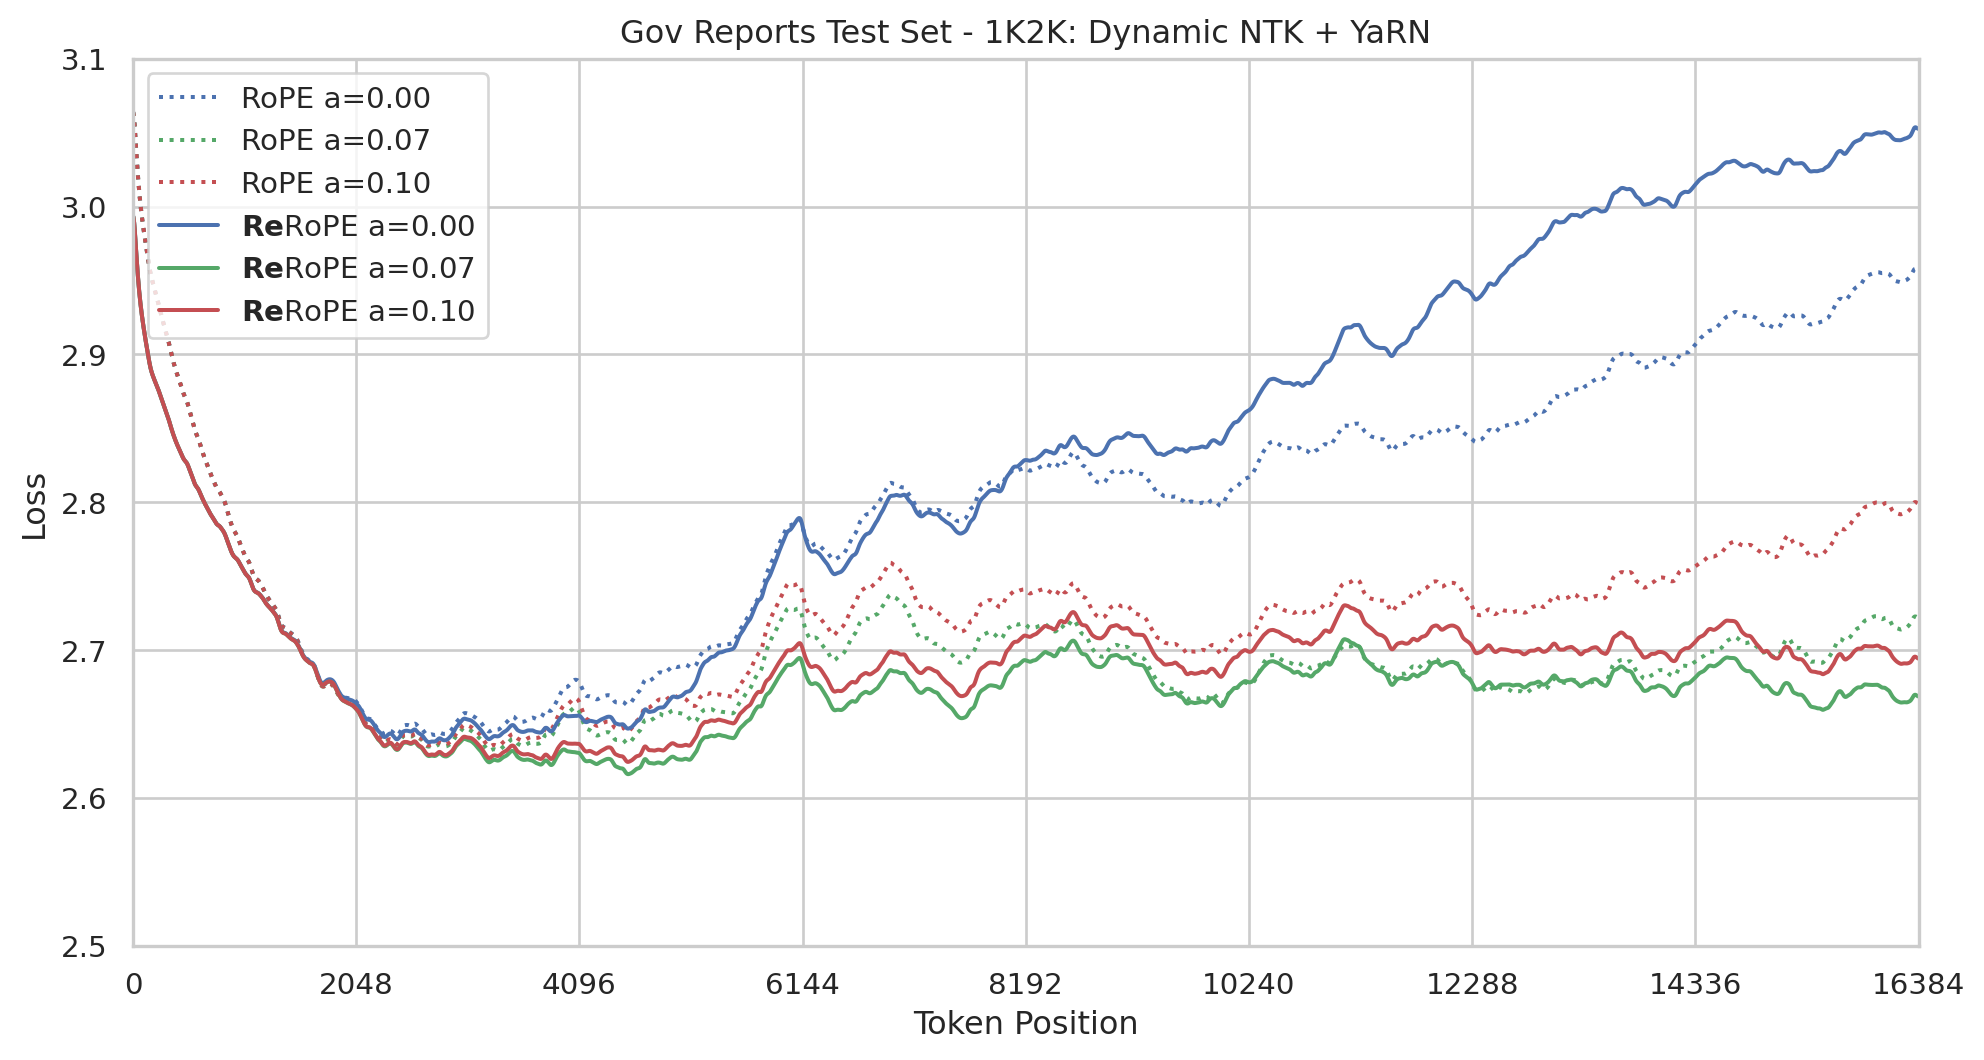

In [29]:
filter_width = 512

plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( ( runningMean( tok_1024_loss_dyn, filter_width ) ), color='C0', linestyle='dotted' )
plt.plot( ( runningMean( tok_1024_loss_yarn, filter_width ) ), color='C2', linestyle='dotted' )
plt.plot( ( runningMean( tok_1024_loss_yarn2, filter_width ) ), color='C3', linestyle='dotted' )

plt.plot( ( runningMean( tok_1024_loss_re_dyn, filter_width ) ), color='C0' )
plt.plot( ( runningMean( tok_1024_loss_re_yarn, filter_width ) ), color='C2' )
plt.plot( ( runningMean( tok_1024_loss_re_yarn2, filter_width ) ), color='C3' )

plt.gca().set_ylim( bottom=2.5, top=3.1 )
plt.gca().set_xlim( left=0, right=e_length )
plt.gca().xaxis.set_major_locator( ticker.MultipleLocator( 2048 ) )
plt.title( 'Gov Reports Test Set - 1K2K: Dynamic NTK + YaRN' )
plt.legend( [ 'RoPE a=0.00',  'RoPE a=0.07', 'RoPE a=0.10', r'$\bf{Re}$RoPE a=0.00', r'$\bf{Re}$RoPE a=0.07', r'$\bf{Re}$RoPE a=0.10' ], loc='upper left' )
plt.ylabel( 'Loss' )
plt.xlabel( 'Token Position' )
plt.show()

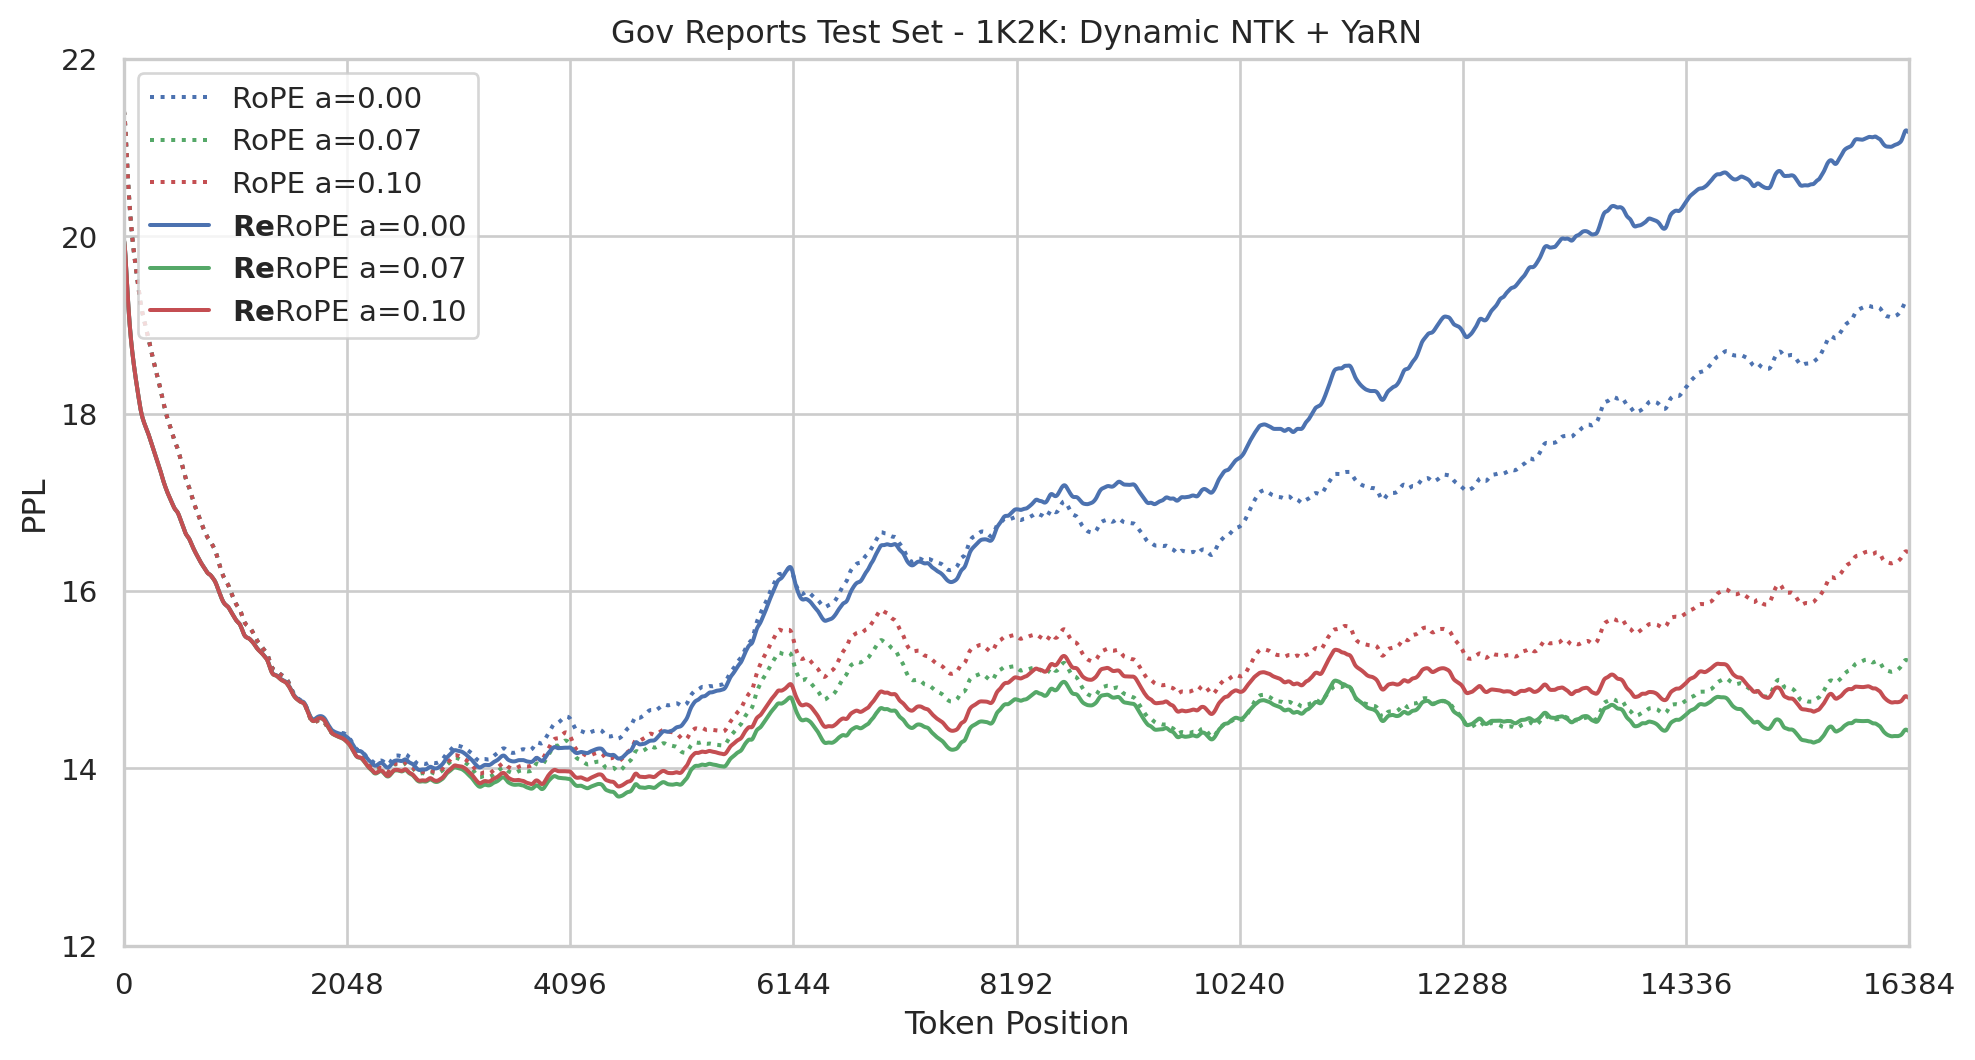

In [31]:
filter_width = 512

plt.figure( 1, ( 12, 6 ), dpi=192 )
plt.plot( np.exp( runningMean( tok_1024_loss_dyn, filter_width ) ), color='C0', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_1024_loss_yarn, filter_width ) ), color='C2', linestyle='dotted' )
plt.plot( np.exp( runningMean( tok_1024_loss_yarn2, filter_width ) ), color='C3', linestyle='dotted' )

plt.plot( np.exp( runningMean( tok_1024_loss_re_dyn, filter_width ) ), color='C0' )
plt.plot( np.exp( runningMean( tok_1024_loss_re_yarn, filter_width ) ), color='C2' )
plt.plot( np.exp( runningMean( tok_1024_loss_re_yarn2, filter_width ) ), color='C3' )

plt.gca().set_ylim( bottom=12, top=22 )
plt.gca().set_xlim( left=0, right=e_length )
plt.gca().xaxis.set_major_locator( ticker.MultipleLocator( 2048 ) )
plt.title( 'Gov Reports Test Set - 1K2K: Dynamic NTK + YaRN' )
plt.legend( [ 'RoPE a=0.00',  'RoPE a=0.07', 'RoPE a=0.10', r'$\bf{Re}$RoPE a=0.00', r'$\bf{Re}$RoPE a=0.07', r'$\bf{Re}$RoPE a=0.10' ], loc='upper left' )
plt.ylabel( 'PPL' )
plt.xlabel( 'Token Position' )
plt.show()

In [33]:
os.system( "jupyter notebook list" )

Currently running servers:
http://0.0.0.0:8888/?token=15f3c94670f04a9a841b01e5e51412bbc92e73ddf430f6a9 :: /home/lhk3/memory-transformer-pt4


0